In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## What this notebook contains

The goal of this notebook is to set-up one of the key experiments contained in my paper. The overall idea is that even when the ground-truth data is generated as a linear regression, the alternating minimization-grad descent scheme is very suboptimal, even when you overparameterize the representation as a powerful neural network (compared to the ground truth representation, which is just a matrix in this case).

To put some math into this, we assume that our data is generated as:
\begin{align*}
    y^{(t)}_i = F^{(t)}_\star \Phi_\star x^{(t)}_i + w^{(t)}_i,\quad y^{(t)}_i \in \mathbb R^{d_y}, x^{(t)}_i \in \mathbb R^{d_x}, \Phi_\star \in \mathbb R^{r \times d_x}.
\end{align*}
where $t$ indexes distinct tasks $t = 1,\dots, T$. For normalization purposes, we assume $\Phi_\star$ has orthonormal rows. In this set of experiments, we simplify things and assume $x^{(t)}_i$ and $w^{(t)}_i$ are independent and identically distributed across all tasks:
\begin{align*}
    x_i^{(t)} \sim \mathcal N (0, \Sigma_x),\;\; w_i^{(t)} \sim \mathcal N(0, \sigma^2 \cdot \mathrm{Id}), \quad \text{for all }i,t.
\end{align*}
Notably, $\Sigma_x \succ 0$ is going to be generated as some covariance matrix that is *non-isotropic*, i.e. not Identity (or any constant scaling of it. We can take a peek at the data generation functions we imported: `from linreg_data import generate_parameters, generate_data`.

In [2]:
def generate_parameters(dx, dy, r, num_tasks):

    # randomly generate covariance of x
    U = 5*torch.eye(dx) + torch.randn(dx, dx)
    Sigma_x = 0.5*(U + U.T)                                # Make Sigma_x symmetric
    Sigma_x = (dx / torch.trace(Sigma_x)) * Sigma_x        # normalize to get Tr(Sigma_x) = dx

    # randomly generate representation Phi
    A = torch.randn(r, dx)
    _, _, Phi = torch.linalg.svd(A, full_matrices = False) # Generate Phi* as random matrix that is then orthonormalized.

    # randomly generate heads F0 (for validation), F1,...,FT (for training)
    F0 = torch.randn(dy, r)
    Fs = []
    Fs.append(F0)
    for i in range(num_tasks):
        gamma = 0.01
        B = torch.randn(dy, dy)
        rot = torch.linalg.matrix_exp(0.5*gamma*(B - B.T)) # Generate heads by randomly applying a rotation to F0
        F = rot @ F0
        Fs.append(F)

    return Fs, Phi, Sigma_x

As one can glean above, the `generate_parameters` is an exceedingly simple way to randomly generate the key parameters of the ground-truth data, which are the heads $F^{(1)},\dots, F^{(T)}$, the representation $\Phi_\star$ and the *non-isotropic* data covariance $\Sigma_x$.

The following function `generate_data` simply generates data $(x^{(t)}_i, y_i^{(t)})$ from said parameters.

In [3]:
# def generate_data(n_points, Fs, Phi, cov_x, mode = 'train'):

#     U, S, V = torch.linalg.svd(cov_x)
#     cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
#     dy = Fs[0].shape[0]
#     dx = Phi.shape[-1]

#     if mode == 'train':
#         X = []
#         Y = []
#         for i in range(1, len(Fs)):                       # for each task 1,...,T
#             M = Fs[i] @ Phi
#             xs = cov_x_sqrt @ torch.randn(dx, n_points)
#             ws = 0.1*torch.randn(dy, n_points)
#             ys = M @ xs + ws

#             X.append(xs)
#             Y.append(ys)
#         return X, Y

#     elif mode == 'test':
#         M = Fs[0] @ Phi
#         xs = cov_x_sqrt @ torch.randn(dx, n_points)
#         ws = torch.randn(dy, n_points)
#         ys = M @ xs + ws

#         return xs, ys


def generate_data(n_points, Fs, Phi, cov_x):
    U, S, V = torch.linalg.svd(cov_x)
    cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
    dy = Fs[0].shape[0]
    dx = Phi.shape[-1]

    X_train, Y_train, X_test, Y_test, Ws = [], [], [], [], []
    # adjust this
    for i in range(len(Fs)):
        M = Fs[i] @ Phi
        xs = cov_x_sqrt @ torch.randn(dx, n_points)
        ws = 0.1 * torch.randn(dy, n_points)
        ys = M @ xs + ws

        train_split = int(0.5 * n_points)
        X_train.append(xs[:, :train_split])
        Y_train.append(ys[:, :train_split])
        X_test.append(xs[:, train_split:])
        Y_test.append(ys[:, train_split:])
        Ws.append(ws)

    return X_train, Y_train, X_test, Y_test, Ws

The only trick we used here is a property of Gaussian random vectors: $x \sim \mathcal N(0, \Sigma_x)$ is equivalent to $x = \Sigma_x^{1/2} v$, $v \sim \mathcal N(0, \mathrm{Id})$.

<!-- With parameter generation and data generation in hand, let us describe the experiment. For each batch of data, we run 4 algorithms/models, all falling under the alternating minimization-descent paradigm. By this we mean, for each update iteration:

1. **(Minimization)** Hold current rep. $\hat\Phi(\cdot)$ fixed. For each task compute the (rep-conditioned) least-squares head:
\begin{align*}
\hat F^{(t)} = \argmin_F \sum_{i=1}^{\texttt{n\_points}} \|y_i^{(t)} - F \hat\Phi (x_i^{(t)}) \|^2.
\end{align*}
2. **(Descent)** Hold the least-squares heads $\hat F^{(1)}, \dots, \hat F^{(T)}$ fixed. Perform a descent step (whatever that may look like depending on the algorithm) on the representation. We usually assume this update can be computed locally for each task and averaged to yield the final update (this is certainly true for grad descent, since $\nabla $ is a linear operator).
\begin{align*}
d^{(t)} &= \mathrm{DescentStep}(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} ), \quad \text{for }t = 1,\dots, T \\
\hat\Phi^{(t)}_{\mathrm{next}} &= \hat\Phi - \eta d^{(t)} \\
\hat\Phi_{\mathrm{next}} &= \frac{1}{T}\sum_{t=1}^T \hat\Phi^{(t)}_{\mathrm{next}} \\
\text{(For certain methods) }\hat\Phi_{\mathrm{next}} &= \mathrm{Postprocess}(\hat\Phi_{\mathrm{next}}).
\end{align*} -->

In [4]:
#Phi is parameterized by a 2 layer nn
class PhiNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(PhiNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
def least_squares_head(X, Y, Phi):
    with torch.no_grad():
        Phi_X = Phi(X)
    l = Y.T @ Phi_X
    r = torch.linalg.inv(Phi_X.T @ Phi_X + 1e-5 * torch.eye(Phi_X.shape[1], device=device))
    return l @ r


In [6]:
import pdb

def excess_risk(X, Y, F, Phi, W):
    with torch.no_grad():
        pred = F @ Phi(X).T
        pred_risk = torch.mean((Y - pred.T) ** 2)

        # used closed form instead
        # true_risk = (W ** 2).mean()
        # pdb.set_trace()
        # true_risk = Y.shape[1] * .01
        # print(f"Pred Risk: {pred_risk.item()}, True Risk: {true_risk}")

    return pred_risk



In [12]:
import random

def experiment(dx, dy, r, T, n, lr, num_steps, batch_size=64):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]  # Exclude the held-out task
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_test[0].to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train on training tasks with batch sampling
    for step in range(num_steps):
        total_loss = 0.0
        optimizer.zero_grad()

        for t in range(1, T + 1):
            # Sample a batch of indices
            num_samples = X_train[t].shape[1]
            batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
            x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
            y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

            # Forward pass
            embeddings = Phi(x_batch)
            F_t = least_squares_head(x_batch, y_batch, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y_batch)

            total_loss += loss / T

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

    # Compute excess risks
    train_excess_risks = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
    avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

    # Held-out task evaluation
    F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
    transfer_coefficient = avg_train_excess_risk / test_excess_risk
    print(f"Avg Train Excess Risk: {avg_train_excess_risk}, Test Excess Risk: {test_excess_risk}")

    return transfer_coefficient


In [13]:
from tqdm.notebook import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000

all_transfer_coefficients = []

# Run multiple trials
for trial in tqdm(range(num_trials), desc="Running Experiments"):
    transfer_coefficient = experiment(dx, dy, r, num_tasks, n, lr, num_steps)
    all_transfer_coefficients.append(transfer_coefficient)




Running Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

Avg Train Excess Risk: 0.40122470259666443, Test Excess Risk: 0.48663485050201416
Avg Train Excess Risk: 0.3123299777507782, Test Excess Risk: 0.28250473737716675
Avg Train Excess Risk: 0.2824741005897522, Test Excess Risk: 0.3588222563266754
Avg Train Excess Risk: 0.33910542726516724, Test Excess Risk: 0.40575480461120605
Avg Train Excess Risk: 0.3487706184387207, Test Excess Risk: 0.4237925708293915
Avg Train Excess Risk: 0.35903316736221313, Test Excess Risk: 0.41648730635643005
Avg Train Excess Risk: 0.3188245892524719, Test Excess Risk: 0.34206533432006836
Avg Train Excess Risk: 0.3089808523654938, Test Excess Risk: 0.4082252085208893
Avg Train Excess Risk: 0.3934482932090759, Test Excess Risk: 0.4264683127403259
Avg Train Excess Risk: 0.34200507402420044, Test Excess Risk: 0.39804524183273315
Avg Train Excess Risk: 0.2995009422302246, Test Excess Risk: 0.3377639055252075
Avg Train Excess Risk: 0.3184828460216522, Test Excess Risk: 0.40792202949523926
Avg Train Excess Risk: 0.3683

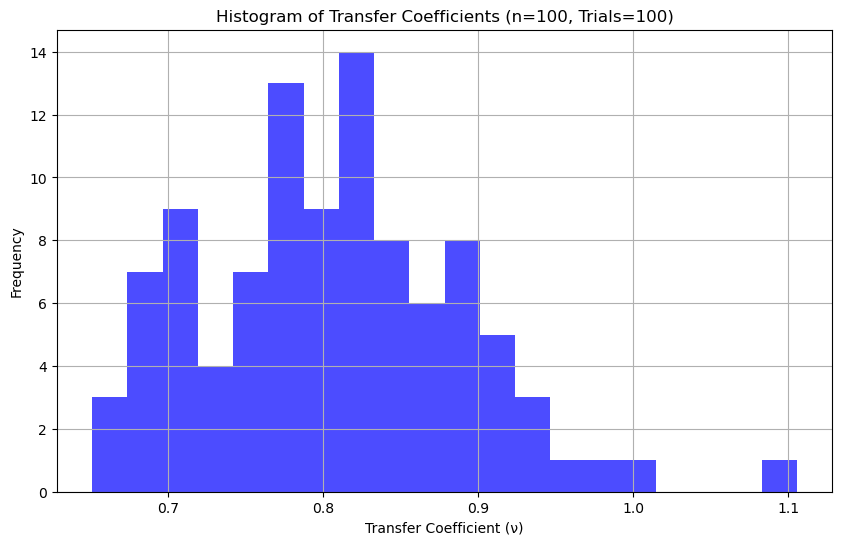

In [14]:
all_transfer_coefficients = torch.tensor(all_transfer_coefficients)

plt.figure(figsize=(10, 6))
plt.hist(all_transfer_coefficients.cpu().numpy(), bins=20, alpha=0.7, color="blue")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Transfer Coefficients (n={n}, Trials={num_trials})")
plt.grid()
plt.show()

Experiments to run:
- Take bad matrix invertible matrix, multiply $\hat{\Phi}$, $Q$,
compare validation loss of the shitty $\Phi$ and unmodified Phi on the same holdout task

- Plot the histogram transfer coefficients on these shitty Q

- Hope to see: Shitty representaiton \implies increase variance, histogram has fatter tails, validation loss is higher

- Run a fixed number of SGD steps

- Future Direction:
We'd like to establish some sort of connection between Differential privacy and task transferability:
Consider  $\hat{\Phi}_1$ and $\hat{\Phi}_2$. trained on different dataasets. We'd like to test which datset the two were
trained on for sufficiently high probability, then we saw that the transfer coefficient \nu is about the same for eahc $\phi

If not, then we can (presumably tell that $\hat{\Phi}_1$ and $\hat{\Phi}_2$ using the target task).


#### Testing to ERM sufficient to enforce transfer

In [15]:
def generate_ill_conditioned_matrix(dim, min_eigenvalue=1e-4, max_eigenvalue=1e4):
    # Generate logarithmically spaced eigenvalues
    eigenvalues = torch.logspace(start=torch.log10(torch.tensor(min_eigenvalue)),
                                 end=torch.log10(torch.tensor(max_eigenvalue)),
                                 steps=dim)

    Q, _ = torch.linalg.qr(torch.randn(dim, dim))
    D = torch.diag(eigenvalues)
    D_inv = torch.diag(1 / (eigenvalues + 1e-10))
    ill_conditioned_matrix = Q @ D @ Q.T
    inv = Q.T @ D_inv @ Q
    return ill_conditioned_matrix.to(device), inv.to(device)

In [16]:
def optimize_head_with_sgd(X, Y, Phi, num_steps=100, lr=0.01):
    dy, r = Y.shape[0], Phi(X.T).shape[1]
    F = torch.nn.Parameter(torch.randn(dy, r, device=device))
    optimizer = optim.SGD([F], lr=lr)
    criterion = nn.MSELoss()

    for step in range(num_steps):
        optimizer.zero_grad()
        embeddings = Phi(X.T)
        preds = F @ embeddings.T
        loss = criterion(preds.T, Y.T)
        loss.backward()
        optimizer.step()

    return F

In [17]:
def experiment_with_bad_representation(dx, dy, r, T, n, lr, num_steps, batch_size, opt="LS"):
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train on training tasks with batch sampling
    for step in range(num_steps):
        total_loss = 0.0

        for t in range(1, T + 1):
            num_samples = X_train[t].shape[1]
            batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
            x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
            y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

            optimizer.zero_grad()
            embeddings = Phi(x_batch)
            F_t = least_squares_head(x_batch, y_batch, Phi)
            preds = embeddings @ F_t.T
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # Evaluate "good" representation
    train_excess_risks_good = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks_good.append(excess_risk(x, y, F_t, Phi, Ws[t]))

    avg_train_excess_risk = torch.tensor(train_excess_risks_good, device=device).mean().item()

    F_heldout_good = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_good = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_good, Phi, Ws[0]).item()
    transfer_coefficient_good = avg_train_excess_risk / test_excess_risk_good

    # Create a "bad" representation
    Q, Q_inv = generate_ill_conditioned_matrix(r)
    Phi_bad = lambda x: (Q @ Phi(x).T).T

    # Phi_{bad} will satisfy ERM with F Q^{-1}, and achieve the same average train ER, so no need to compute it again
    F_heldout_bad = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi_bad)
    test_excess_risk_bad = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_bad, Phi_bad, Ws[0]).item()
    transfer_coefficient_bad = avg_train_excess_risk / test_excess_risk_bad

    # Output results
    print(f"Bad Representation  - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_bad}, Transfer Coefficient: {transfer_coefficient_bad}")
    print(f"Good Representation - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_good}, Transfer Coefficient: {transfer_coefficient_good}")

    return transfer_coefficient_good, transfer_coefficient_bad


# Experiment parameters
dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100
lr = 0.01
num_steps = 1000
batch_size = 32

transfer_coefficients_good = []
transfer_coefficients_bad = []

for trial in tqdm(range(num_trials), desc="Running Experiments with ERM"):
    tc_good, tc_bad = experiment_with_bad_representation(dx, dy, r, num_tasks, n, lr, num_steps, batch_size)
    transfer_coefficients_good.append(tc_good)
    transfer_coefficients_bad.append(tc_bad)


Running Experiments with ERM:   0%|          | 0/100 [00:00<?, ?it/s]

Bad Representation  - Avg Train ER: 0.21100115776062012, Test ER: 68047.8046875, Transfer Coefficient: 3.1007783238506128e-06
Good Representation - Avg Train ER: 0.21100115776062012, Test ER: 0.2542593479156494, Transfer Coefficient: 0.8298658810004491
Bad Representation  - Avg Train ER: 0.144077330827713, Test ER: 1.5821200609207153, Transfer Coefficient: 0.09106599074653485
Good Representation - Avg Train ER: 0.144077330827713, Test ER: 0.15652364492416382, Transfer Coefficient: 0.920482850354775
Bad Representation  - Avg Train ER: 0.17635320127010345, Test ER: 3.5369973182678223, Transfer Coefficient: 0.04985958014705793
Good Representation - Avg Train ER: 0.17635320127010345, Test ER: 0.23802608251571655, Transfer Coefficient: 0.7408986418892101
Bad Representation  - Avg Train ER: 0.2135460376739502, Test ER: 8.011014938354492, Transfer Coefficient: 0.026656552174375767
Good Representation - Avg Train ER: 0.2135460376739502, Test ER: 0.27718421816825867, Transfer Coefficient: 0.770

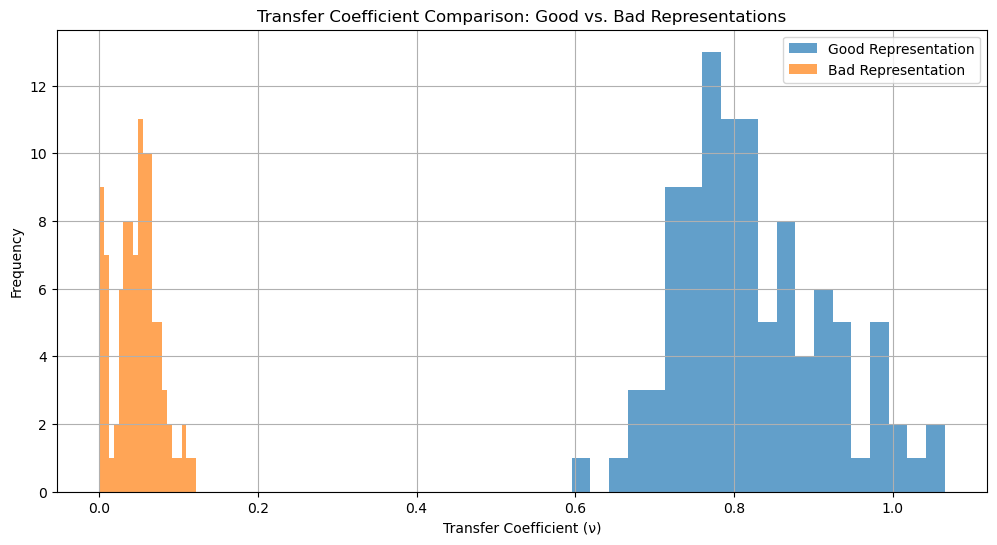

In [18]:
plt.figure(figsize=(12, 6))

plt.hist(torch.tensor(transfer_coefficients_good).cpu().numpy(), bins=20, alpha=0.7, label="Good Representation")
plt.hist(torch.tensor(transfer_coefficients_bad).cpu().numpy(), bins=20, alpha=0.7, label="Bad Representation")

plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Transfer Coefficient Comparison: Good vs. Bad Representations")
plt.legend()
plt.grid()
plt.show()

In [19]:
def experiment_with_bad_representation(dx, dy, r, T, n, lr, num_steps, batch_size, opt="LS"):
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_test[0].to(device)

    # Initialize model (Phi is fixed after training)
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.Adam(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train representation Phi on training tasks using batch sampling
    for step in range(num_steps):
        for t in range(1, T + 1):
            num_samples = X_train[t].shape[1]
            batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
            x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
            y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

            optimizer.zero_grad()
            embeddings = Phi(x_batch)
            F_t = least_squares_head(x_batch, y_batch, Phi)
            preds = embeddings @ F_t.T
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate "good" representation
    train_excess_risks_good = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks_good.append(excess_risk(x, y, F_t, Phi, Ws[t]))

    avg_train_excess_risk = torch.tensor(train_excess_risks_good, device=device).mean().item()

    # Evaluate "good" representation on holdout task
    F_heldout_good = None
    if opt == "LS":
        F_heldout_good = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    elif opt == "GD":
        F_heldout_good = torch.nn.Parameter(torch.randn(dy, r, device=device) * 0.1)
        optimizer_head_good = optim.Adam([F_heldout_good], lr=0.01)
        for step in range(1000):
            optimizer_head_good.zero_grad()
            embeddings_good = Phi(X_holdout_train.T)
            preds_good = F_heldout_good @ embeddings_good.T
            loss_good = criterion(preds_good.T, Y_holdout_train.T)
            loss_good.backward()
            optimizer_head_good.step()

    test_excess_risk_good = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_good, Phi, Ws[0]).item()
    transfer_coefficient_good = avg_train_excess_risk / test_excess_risk_good

    # Create a "bad" representation
    Q, Q_inv = generate_ill_conditioned_matrix(r)
    Phi_bad = lambda x: (Q @ Phi(x).T).T

    # Evaluate "bad" representation on holdout task
    F_heldout_bad = None
    if opt == "LS":
        F_heldout_bad = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi_bad)
    elif opt == "GD":
        F_heldout_bad = torch.nn.Parameter(torch.randn(dy, r, device=device) * 0.1)
        optimizer_head_bad = optim.Adam([F_heldout_bad], lr=0.001)
        for step in range(1000):
            optimizer_head_bad.zero_grad()
            embeddings_bad = Phi_bad(X_holdout_train.T)
            preds_bad = F_heldout_bad @ embeddings_bad.T
            loss_bad = criterion(preds_bad.T, Y_holdout_train.T)
            loss_bad.backward()
            optimizer_head_bad.step()

    test_excess_risk_bad = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout_bad, Phi_bad, Ws[0]).item()
    transfer_coefficient_bad = avg_train_excess_risk / test_excess_risk_bad

    # Output results
    print(f"Bad Representation  - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_bad}, Transfer Coefficient: {transfer_coefficient_bad}")
    print(f"Good Representation - Avg Train ER: {avg_train_excess_risk}, Test ER: {test_excess_risk_good}, Transfer Coefficient: {transfer_coefficient_good}")

    return transfer_coefficient_good, transfer_coefficient_bad


# Experiment parameters
dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100
lr = 0.01
num_steps = 1000
batch_size = 32

transfer_coefficients_good = []
transfer_coefficients_bad = []

for trial in tqdm(range(num_trials), desc="Running Experiments with Batch Sampling"):
    tc_good, tc_bad = experiment_with_bad_representation(dx, dy, r, num_tasks, n, lr, num_steps, batch_size, opt="GD")
    transfer_coefficients_good.append(tc_good)
    transfer_coefficients_bad.append(tc_bad)


Running Experiments with Batch Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

Bad Representation  - Avg Train ER: 0.0315985381603241, Test ER: 45605.8359375, Transfer Coefficient: 6.92861725057029e-07
Good Representation - Avg Train ER: 0.0315985381603241, Test ER: 0.035236697643995285, Transfer Coefficient: 0.8967508385596069
Bad Representation  - Avg Train ER: 0.037882812321186066, Test ER: 36761.75390625, Transfer Coefficient: 1.030495237463234e-06
Good Representation - Avg Train ER: 0.037882812321186066, Test ER: 0.049995504319667816, Transfer Coefficient: 0.7577243761552233
Bad Representation  - Avg Train ER: 0.03512166067957878, Test ER: 46602.57421875, Transfer Coefficient: 7.536420738202052e-07
Good Representation - Avg Train ER: 0.03512166067957878, Test ER: 0.051233530044555664, Transfer Coefficient: 0.6855209986318518
Bad Representation  - Avg Train ER: 0.03168408200144768, Test ER: 96334.8984375, Transfer Coefficient: 3.2889516172587887e-07
Good Representation - Avg Train ER: 0.03168408200144768, Test ER: 0.04368438571691513, Transfer Coefficient: 0.

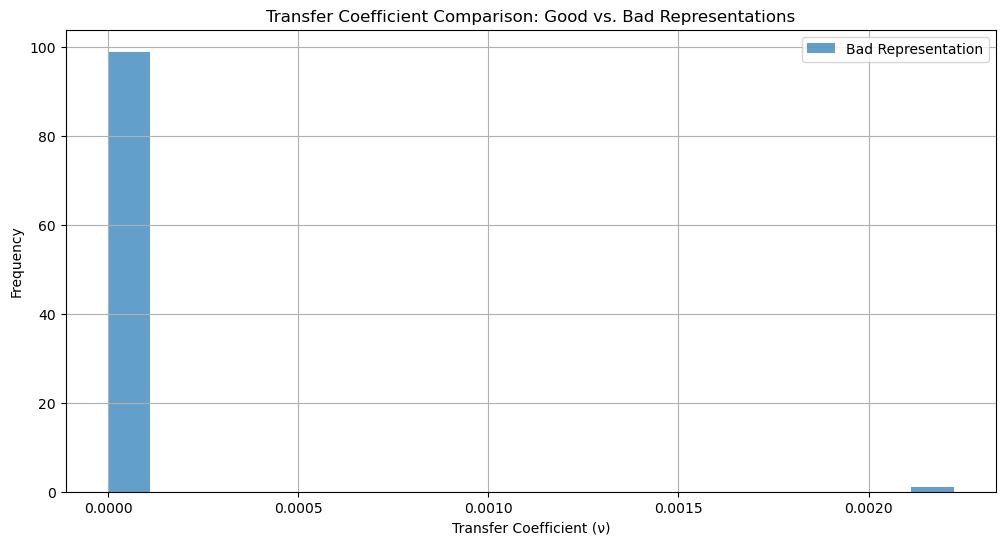

In [29]:
plt.figure(figsize=(12, 6))

plt.hist(torch.tensor(transfer_coefficients_bad).cpu().numpy(), bins=20, alpha=0.7, label="Bad Representation")

plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Transfer Coefficient Comparison: Good vs. Bad Representations")
plt.legend()
plt.grid()
plt.show()

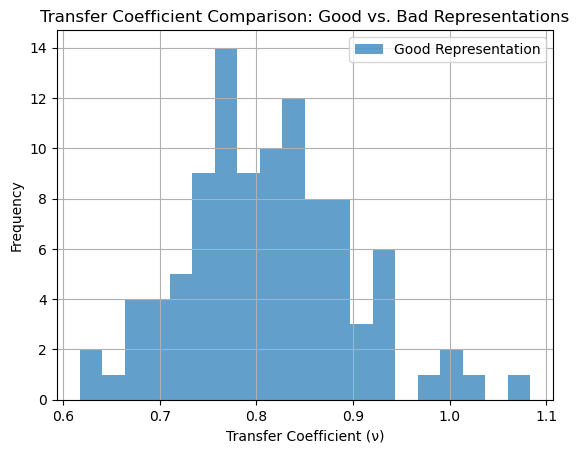

In [30]:
plt.hist(torch.tensor(transfer_coefficients_good).cpu().numpy(), bins=20, alpha=0.7, label="Good Representation")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Transfer Coefficient Comparison: Good vs. Bad Representations")
plt.legend()
plt.grid()
plt.show()

### Evolution of transfer coeff while updating representation

In [7]:
def experiment_GD(dx, dy, r, T, n, lr, num_steps, batch_size):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()
    transfer_coeff_over_time = []

    # Train on training tasks using batch sampling
    for step in range(num_steps):
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(1, T + 1):
            num_samples = X_train[t].shape[1]
            batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
            x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
            y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

            embeddings = Phi(x_batch)
            F_t = least_squares_head(x_batch, y_batch, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y_batch)

            total_loss += loss / T

        total_loss.backward()
        optimizer.step()

        # Compute excess risks
        if step % 5 == 0:
            train_excess_risks = []
            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
            avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

            # Held-out task evaluation
            F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
            test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
            transfer_coefficient = avg_train_excess_risk / test_excess_risk
            transfer_coeff_over_time.append(transfer_coefficient)

    return transfer_coeff_over_time


## SGD/DP-SGD

In [ ]:
def experiment_DPGD(dx, dy, r, T, n, lr, num_steps, batch_size):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()
    transfer_coeff_over_time = []

    # Train on training tasks using DP-SGD with batch sampling
    for step in range(num_steps):
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(1, T + 1):
            num_samples = X_train[t].shape[1]
            batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
            x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
            y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

            embeddings = Phi(x_batch)
            F_t = least_squares_head(x_batch, y_batch, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y_batch)
            total_loss += loss / T

        # Apply DP-SGD steps
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(Phi.parameters(), max_norm=1.0)  # Gradient clipping
        for param in Phi.parameters():
            param.grad += 0.5 * torch.randn_like(param.grad)  # Add Gaussian noise for differential privacy
        optimizer.step()

        # Compute excess risks
        if step % 5 == 0:
            train_excess_risks = []
            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
            avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

            # Held-out task evaluation
            F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
            test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
            transfer_coefficient = avg_train_excess_risk / test_excess_risk
            transfer_coeff_over_time.append(transfer_coefficient)

    return transfer_coeff_over_time


Running Experiments (DP-SGD): 100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


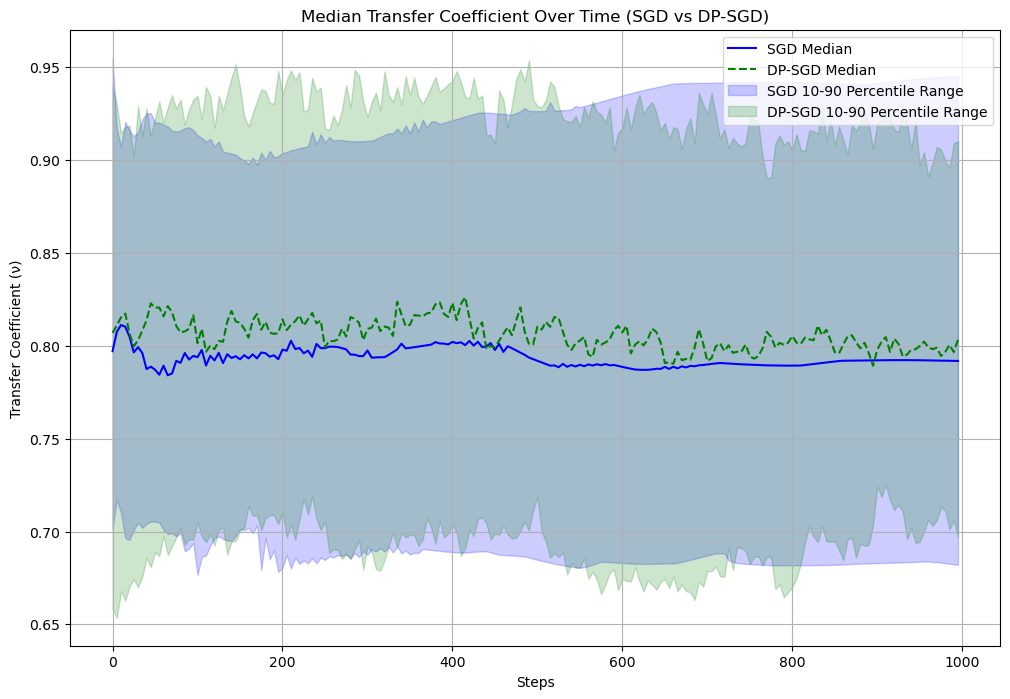

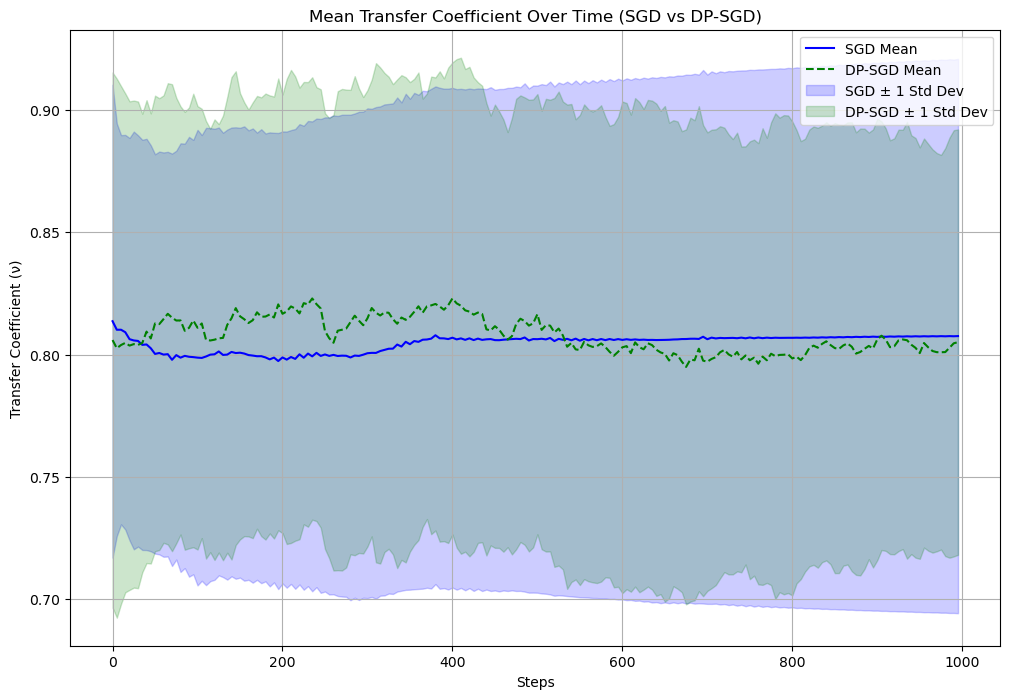

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def run_experiment(dx, dy, r, T, n, lr, num_steps, dp=False):
    all_transfer_coefficients_over_time = []

    if dp:
        experiment = experiment_DPGD
    else:
        experiment = experiment_GD

    for trial in tqdm(range(num_trials), desc=f"Running Experiments ({'DP-SGD' if dp else 'SGD'})"):
        transfer_coefficient = experiment(dx, dy, r, T, n, lr, num_steps)
        all_transfer_coefficients_over_time.append(transfer_coefficient)

    return np.array(all_transfer_coefficients_over_time)


# Parameters
dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100
lr = 0.01
num_steps = 1000
updates = np.array(range(0, num_steps, 5))

# Run experiments for SGD and DP-SGD
sgd_results = run_experiment(dx, dy, r, num_tasks, n, lr, num_steps, dp=False)
dp_sgd_results = run_experiment(dx, dy, r, num_tasks, n, lr, num_steps, dp=True)

# Compute statistics
def compute_statistics(results):
    median = np.median(results, axis=0)
    mean = np.mean(results, axis=0)
    std = np.std(results, axis=0)
    percentile_10 = np.percentile(results, 10, axis=0)
    percentile_90 = np.percentile(results, 90, axis=0)
    return median, mean, std, percentile_10, percentile_90

sgd_median, sgd_mean, sgd_std, sgd_p10, sgd_p90 = compute_statistics(sgd_results)
dp_median, dp_mean, dp_std, dp_p10, dp_p90 = compute_statistics(dp_sgd_results)

# Plot median overlay
plt.figure(figsize=(12, 8))
plt.plot(updates, sgd_median, label="SGD Median", color="blue", linestyle="-")
plt.plot(updates, dp_median, label="DP-SGD Median", color="green", linestyle="--")
plt.fill_between(updates, sgd_p10, sgd_p90, color="blue", alpha=0.2, label="SGD 10-90 Percentile Range")
plt.fill_between(updates, dp_p10, dp_p90, color="green", alpha=0.2, label="DP-SGD 10-90 Percentile Range")

plt.xlabel("Steps")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Median Transfer Coefficient Over Time (SGD vs DP-SGD)")
plt.legend()
plt.grid()
plt.show()

# Plot mean overlay
plt.figure(figsize=(12, 8))
plt.plot(updates, sgd_mean, label="SGD Mean", color="blue", linestyle="-")
plt.plot(updates, dp_mean, label="DP-SGD Mean", color="green", linestyle="--")
plt.fill_between(updates, sgd_mean - sgd_std, sgd_mean + sgd_std, color="blue", alpha=0.2, label="SGD ± 1 Std Dev")
plt.fill_between(updates, dp_mean - dp_std, dp_mean + dp_std, color="green", alpha=0.2, label="DP-SGD ± 1 Std Dev")

plt.xlabel("Steps")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Mean Transfer Coefficient Over Time (SGD vs DP-SGD)")
plt.legend()
plt.grid()
plt.show()


Epsilon Values: 100%|██████████| 10/10 [04:30<00:00, 27.03s/it]


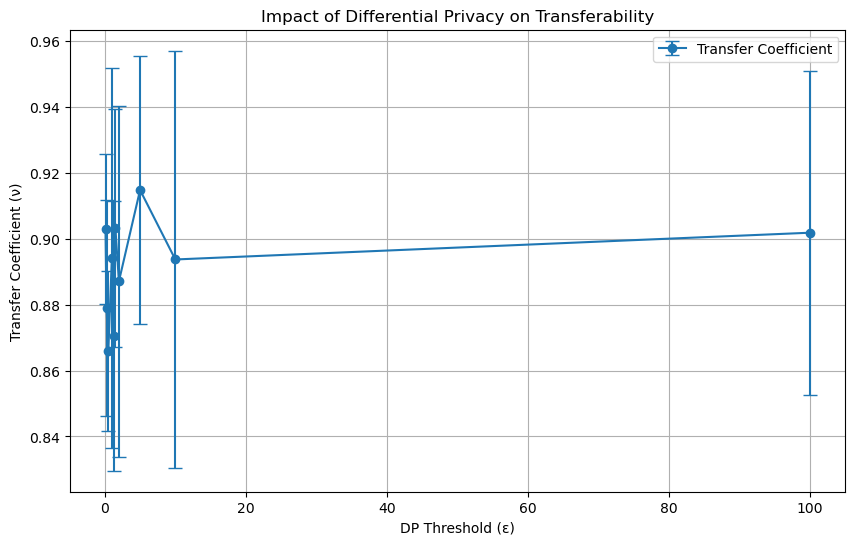

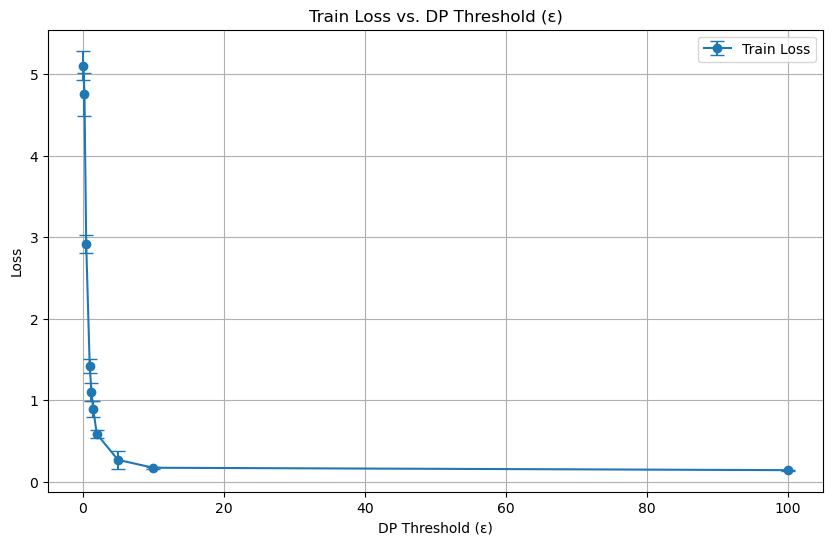

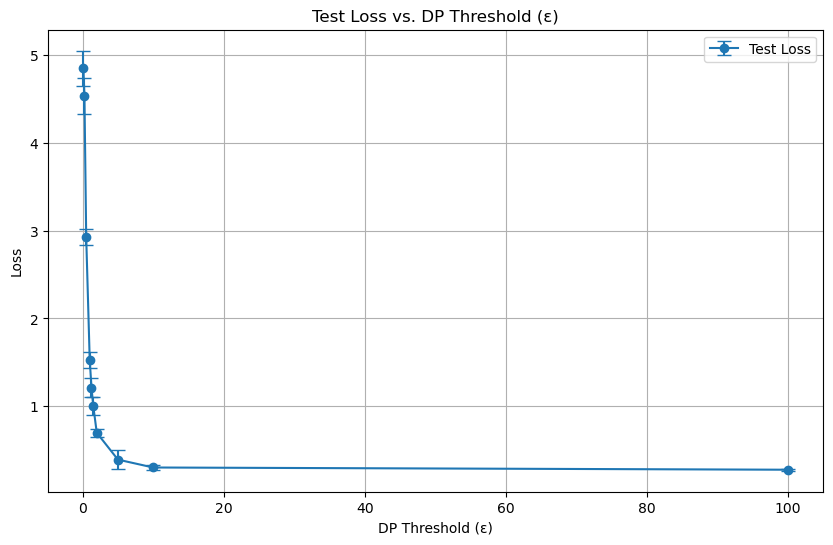

In [35]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

def dp_noise(grad, sensitivity, epsilon):
    """
    Add Gaussian noise to gradients for Differential Privacy.
    """
    sigma = sensitivity / epsilon  # Noise scale
    noise = torch.normal(mean=0, std=sigma, size=grad.size(), device=grad.device)
    return grad + noise

def dp_training_experiment(dx, dy, r, T, n, lr, num_steps, epsilons, batch_size=64, sensitivity=1.0):
    """
    Train models with Differential Privacy and batch sampling, track losses, and measure transfer coefficients.
    """
    # Generate parameters and data once for all trials
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    transfer_coefficients = []
    train_losses = []
    test_losses = []

    for epsilon in tqdm(epsilons, desc="Epsilon Values", leave=True):
        transfer_coeff_eps = []
        train_losses_eps = []
        test_losses_eps = []

        for trial in tqdm(range(10), desc=f"Trials for ε={epsilon:.1f}", leave=False):
            # Initialize model
            Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
            optimizer = optim.SGD(Phi.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Train with DP and batch sampling
            for step in range(num_steps):
                optimizer.zero_grad()
                total_loss = 0.0

                for t in range(1, T + 1):
                    num_samples = X_train[t].shape[1]
                    batch_indices = random.sample(range(num_samples), min(batch_size, num_samples))
                    x_batch = X_train[t][:, batch_indices].T  # Shape: (batch_size, dx)
                    y_batch = Y_train[t][:, batch_indices].T  # Shape: (batch_size, dy)

                    embeddings = Phi(x_batch)
                    F_t = least_squares_head(x_batch, y_batch, Phi)
                    preds = F_t @ embeddings.T
                    loss = criterion(preds.T, y_batch)
                    total_loss += loss / T

                total_loss.backward()

                # Add DP noise to gradients
                for param in Phi.parameters():
                    param.grad = dp_noise(param.grad, sensitivity, epsilon)

                optimizer.step()

            # Compute train and test losses
            train_loss = 0.0
            for t in range(1, T + 1):
                x = X_train[t].T
                y = Y_train[t].T
                F_t = least_squares_head(x, y, Phi)
                preds = F_t @ Phi(x).T
                train_loss += criterion(preds.T, y).item() / T

            test_loss = 0.0
            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                preds = F_t @ Phi(x).T
                test_loss += criterion(preds.T, y).item() / T

            train_losses_eps.append(train_loss)
            test_losses_eps.append(test_loss)

            # Compute transfer coefficient
            F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
            test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
            train_excess_risks = []

            for t in range(1, T + 1):
                x = X_test[t].T
                y = Y_test[t].T
                F_t = least_squares_head(x, y, Phi)
                train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))

            avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()
            transfer_coeff_eps.append(avg_train_excess_risk / test_excess_risk)

        transfer_coefficients.append(transfer_coeff_eps)
        train_losses.append(train_losses_eps)
        test_losses.append(test_losses_eps)

    return transfer_coefficients, train_losses, test_losses



# Experiment parameters
epsilons = [0.1, 0.25, 0.5, 1.0, 1.25, 1.5, 2.0, 5, 10, 100]  # Privacy thresholds
dx, dy, r = 50, 15, 5
num_tasks = 10
n = 200
lr = 0.01
num_steps = 500

# Run DP training experiment
transfer_coefficients_dp, train_losses, test_losses = dp_training_experiment(
    dx, dy, r, num_tasks, n, lr, num_steps, epsilons
)

# Convert results to numpy arrays
transfer_coefficients_dp = np.array(transfer_coefficients_dp)  # Shape: (len(epsilons), num_trials)
train_losses = np.array(train_losses)  # Shape: (len(epsilons), num_trials)
test_losses = np.array(test_losses)  # Shape: (len(epsilons), num_trials)

# Compute statistics for transfer coefficients
mean_transfer_coeffs = np.mean(transfer_coefficients_dp, axis=1)
std_transfer_coeffs = np.std(transfer_coefficients_dp, axis=1)

# Compute statistics for train and test losses
mean_train_losses = np.mean(train_losses, axis=1)
std_train_losses = np.std(train_losses, axis=1)
mean_test_losses = np.mean(test_losses, axis=1)
std_test_losses = np.std(test_losses, axis=1)

# Plot transfer coefficients
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_transfer_coeffs, yerr=std_transfer_coeffs, fmt='-o', capsize=5, label="Transfer Coefficient")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Transfer Coefficient (ν)")
plt.title("Impact of Differential Privacy on Transferability")
plt.grid()
plt.legend()
plt.show()

# Plot train losses
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_train_losses, yerr=std_train_losses, fmt='-o', capsize=5, label="Train Loss")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Loss")
plt.title("Train Loss vs. DP Threshold (ε)")
plt.grid()
plt.legend()
plt.show()

# Plot test losses
plt.figure(figsize=(10, 6))
plt.errorbar(epsilons, mean_test_losses, yerr=std_test_losses, fmt='-o', capsize=5, label="Test Loss")
plt.xlabel("DP Threshold (ε)")
plt.ylabel("Loss")
plt.title("Test Loss vs. DP Threshold (ε)")
plt.grid()
plt.legend()
plt.show()


T-Statistic: -0.5578285523677754, P-Value: 0.580233205894218


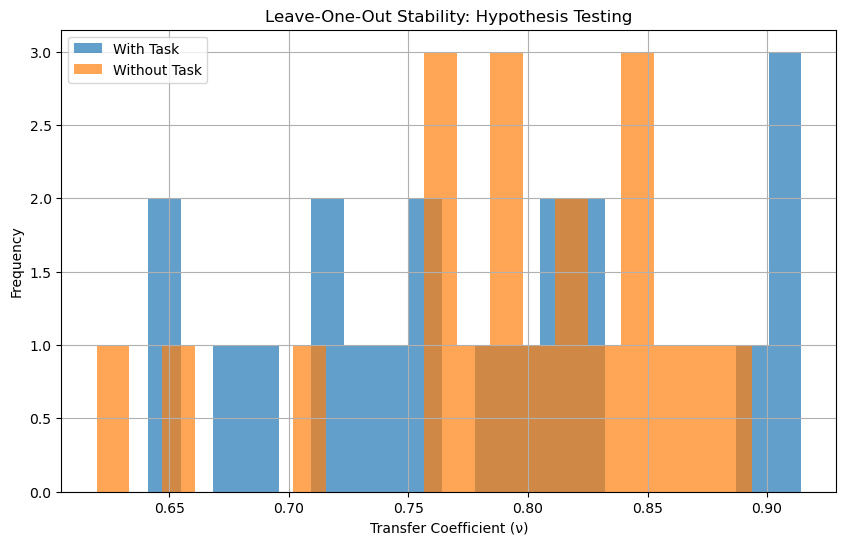

In [ ]:
from scipy.stats import ttest_ind

def hypothesis_testing_experiment(dx, dy, r, T, n, lr, num_steps, num_trials=20):
    """
    Hypothesis testing experiment to evaluate if two learned representations
    trained with and without a specific task are significantly different.
    """
    transfer_coeffs_with_task, transfer_coeffs_without_task = [], []
    
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    for trial in range(num_trials):
        # Train representation WITH the task
        Phi_with = PhiNet(input_dim=dx, output_dim=r).to(device)
        optimizer_with = optim.SGD(Phi_with.parameters(), lr=lr)
        criterion = nn.MSELoss()
        for step in range(num_steps):
            optimizer_with.zero_grad()
            total_loss = 0.0
            for t in range(1, T + 1):  # Include all tasks
                x = X_train[t].T
                y = Y_train[t].T
                embeddings = Phi_with(x)
                F_t = least_squares_head(x, y, Phi_with)
                preds = F_t @ embeddings.T
                loss = criterion(preds.T, y)
                total_loss += loss / T
            total_loss.backward()
            optimizer_with.step()

        # Train representation WITHOUT the task (leave-one-out)
        excluded_task = random.choice(range(1, T + 1))  # Randomly exclude a task
        Phi_without = PhiNet(input_dim=dx, output_dim=r).to(device)
        optimizer_without = optim.SGD(Phi_without.parameters(), lr=lr)
        for step in range(num_steps):
            optimizer_without.zero_grad()
            total_loss = 0.0
            for t in range(1, T + 1):
                if t == excluded_task:
                    continue  # Skip the excluded task
                x = X_train[t].T
                y = Y_train[t].T
                embeddings = Phi_without(x)
                F_t = least_squares_head(x, y, Phi_without)
                preds = F_t @ embeddings.T
                loss = criterion(preds.T, y)
                total_loss += loss / (T - 1)  # Adjust normalization
            total_loss.backward()
            optimizer_without.step()

        # Evaluate transfer coefficients for representation WITH the task
        F_heldout_with = least_squares_head(X_train[0].T, Y_train[0].T, Phi_with)
        test_excess_risk_with = excess_risk(X_test[0].T, Y_test[0].T, F_heldout_with, Phi_with, Ws[0]).item()
        train_excess_risks_with = []
        for t in range(1, T + 1):
            x = X_test[t].T
            y = Y_test[t].T
            F_t = least_squares_head(x, y, Phi_with)
            train_excess_risks_with.append(excess_risk(x, y, F_t, Phi_with, Ws[t]))
        avg_train_excess_risk_with = torch.tensor(train_excess_risks_with, device=device).mean().item()
        transfer_coeff_with = avg_train_excess_risk_with / test_excess_risk_with
        transfer_coeffs_with_task.append(transfer_coeff_with)

        # Evaluate transfer coefficients for representation WITHOUT the task
        F_heldout_without = least_squares_head(X_train[0].T, Y_train[0].T, Phi_without)
        test_excess_risk_without = excess_risk(X_test[0].T, Y_test[0].T, F_heldout_without, Phi_without, Ws[0]).item()
        train_excess_risks_without = []
        for t in range(1, T + 1):
            if t == excluded_task:
                continue  # Skip the excluded task
            x = X_test[t].T
            y = Y_test[t].T
            F_t = least_squares_head(x, y, Phi_without)
            train_excess_risks_without.append(excess_risk(x, y, F_t, Phi_without, Ws[t]))
        avg_train_excess_risk_without = torch.tensor(train_excess_risks_without, device=device).mean().item()
        transfer_coeff_without = avg_train_excess_risk_without / test_excess_risk_without
        transfer_coeffs_without_task.append(transfer_coeff_without)

    # Perform t-test for hypothesis testing
    t_stat, p_value = ttest_ind(transfer_coeffs_with_task, transfer_coeffs_without_task)
    return transfer_coeffs_with_task, transfer_coeffs_without_task, t_stat, p_value

# Run the experiment
transfer_coeffs_with_task, transfer_coeffs_without_task, t_stat, p_value = hypothesis_testing_experiment(
    dx=50, dy=15, r=5, T=10, n=100, lr=0.01, num_steps=500, num_trials=20
)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Plot results
plt.figure(figsize=(10, 6))
plt.hist(transfer_coeffs_with_task, bins=20, alpha=0.7, label="With Task")
plt.hist(transfer_coeffs_without_task, bins=20, alpha=0.7, label="Without Task")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title("Leave-One-Out Stability: Hypothesis Testing")
plt.legend()
plt.grid()
plt.show()


## Using predictor of $\nu$ to take regularized sgd step before fitting holdout task

In [19]:
import pdb

class GNet(nn.Module):
    def __init__(self, embedding_dim, output_dim, hidden_dim=64):
        super(GNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, flattened_input):
        return self.layers(flattened_input)

def experiment(data, dx, dy, r, T, lr_phi, lr_g, num_steps, batch_size=64, split_ratio=0.8, reg_param=1):
    """
    Run the experiment with pre-generated data.

    Args:
        data: Tuple containing pre-generated data (F_star, Phi_star, Sigma_x, X_train, Y_train, X_test, Y_test, Ws).
        dx, dy, r, T: Dimensions and task count.
        lr_phi, lr_g: Learning rates for Φ and G.
        num_steps: Number of training steps.
        batch_size: Batch size for sampling.
        split_ratio: Ratio to split training data for risk computation.
        reg_param: Regularization parameter for G-based training.

    Returns:
        g_train_losses, transfer_coeff_before, transfer_coeff_after, avg_train_excess_risk_before,
        avg_train_excess_risk_after, test_excess_risk_before, test_excess_risk_after
    """
    # Unpack pre-generated data
    X_train, Y_train, X_test, Y_test, Ws = data

    # Partition data for training, risk computation, and validation
    X_phi_train, Y_phi_train, X_risk, Y_risk = [], [], [], []
    for t in range(T):
        split_idx = int(split_ratio * X_train[t].shape[1])
        X_phi_train.append(X_train[t][:, :split_idx].to(device))  # Training subset
        Y_phi_train.append(Y_train[t][:, :split_idx].to(device))
        X_risk.append(X_train[t][:, split_idx:].to(device))       # Excess risk subset
        Y_risk.append(Y_train[t][:, split_idx:].to(device))

    # Separate holdout task
    X_holdout_train, Y_holdout_train = X_train[-1][:, :split_idx].to(device), Y_train[-1][:, :split_idx].to(device)
    X_holdout_test, Y_holdout_test = X_test[-1].to(device), Y_test[-1].to(device)
    Ws = [w.to(device) for w in Ws]

    # Initialize models and optimizers
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    G_model = GNet(embedding_dim=4339, output_dim=1).to(device)  # Adjust input size for flattened embeddings
    optimizer_phi = optim.SGD(Phi.parameters(), lr=lr_phi)
    optimizer_g = optim.SGD(G_model.parameters(), lr=lr_g)
    criterion = nn.MSELoss()
    g_criterion = nn.MSELoss()
    g_train_losses = []

    # Helper: Sample a random batch
    def get_batch(X, Y, batch_size):
        indices = torch.randperm(X.shape[1])[:batch_size]
        return X[:, indices], Y[:, indices]

    # Training loop
    for step in tqdm(range(num_steps), desc="Training Steps"):
        # Step 1: Train Φ with batch sampling
        optimizer_phi.zero_grad()
        total_loss = 0.0
        for t in range(T):
            x_batch, y_batch = get_batch(X_phi_train[t], Y_phi_train[t], batch_size)
            embeddings = Phi(x_batch.T)
            F_t = least_squares_head(x_batch.T, y_batch.T, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y_batch.T)
            total_loss += loss
        total_loss.backward()
        optimizer_phi.step()

        # Compute excess risks and heads for G training
        heads = [least_squares_head(X_risk[t].T, Y_risk[t].T, Phi) for t in range(T)]
        flattened_heads = [h.flatten() for h in heads]
        flattened_Phi = torch.cat([p.flatten() for p in Phi.parameters()], dim=0)
        excess_risks = torch.tensor(
            [excess_risk(X_risk[t].T, Y_risk[t].T, heads[t], Phi, Ws[t])
             for t in range(T)], device=device)

        # Step 2: Train G with batch sampling
        optimizer_g.zero_grad()
        masks = ~torch.eye(T, dtype=torch.bool, device=device)
        remaining_excess_risks = torch.sum(excess_risks.unsqueeze(0) * masks, dim=1)
        avg_remaining_excess_risks = remaining_excess_risks / masks.sum(dim=1)
        transfer_coeffs = avg_remaining_excess_risks / excess_risks

        g_train_loss = 0.0
        for t in range(T):
            flattened_input = torch.cat(
                [flattened_Phi, torch.cat(flattened_heads[:t] + flattened_heads[t + 1:], dim=0), flattened_heads[t]],
                dim=0
            )
            g_preds = G_model(flattened_input.unsqueeze(0))
            g_train_loss += g_criterion(g_preds.squeeze(), transfer_coeffs[t].detach())
        g_train_loss.backward()
        optimizer_g.step()
        g_train_losses.append(g_train_loss.item())

    F_holdout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_before = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout, Phi, Ws[-1])
    avg_train_excess_risk_before = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_before = avg_train_excess_risk_before / test_excess_risk_before.item()

    # Single Update on Φ Using G with Leave-One-Out Regularization
    optimizer_phi.zero_grad()
    regularizations = []
    for leave_out_t in range(T):
        flattened_input = torch.cat(
            [
                flattened_Phi,
                torch.cat(flattened_heads[:leave_out_t] + flattened_heads[leave_out_t + 1:], dim=0),
                flattened_heads[leave_out_t]
            ],
            dim=0
        )
        regularization = G_model(flattened_input.unsqueeze(0)).item()
        regularizations.append(regularization)

    avg_regularization = sum(regularizations) / T
    # pdb.set_trace()

    pred = F_holdout @ Phi(X_holdout_train.T).T
    gt =  Y_holdout_train
   
    loss = criterion(pred, gt) + reg_param * avg_regularization
    loss.backward()
    optimizer_phi.step()

    # Evaluate Transfer Coefficients AFTER Holdout Update
    F_holdout_updated = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_after = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout_updated, Phi, Ws[-1])
    avg_train_excess_risk_after = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_after = avg_train_excess_risk_after / test_excess_risk_after.item()

    return (
        g_train_losses,
        transfer_coeff_before,
        transfer_coeff_after,
        avg_train_excess_risk_before,
        avg_train_excess_risk_after,
        test_excess_risk_before.item(),
        test_excess_risk_after.item(),
    )


# Generate data for testing
dx, dy, r, T = 50, 15, 5, 10  # Dimensions and tasks
n = 320  # Number of samples per task
lr_phi = 0.01
lr_g = 0.001
num_steps = 100
batch_size = 32
reg_param = 10

# Generate dataset
params = generate_parameters(dx, dy, r, T)
params = [n] + list(params)
data = generate_data(*params)

# Call the experiment function
results = experiment(data, dx, dy, r, T, lr_phi, lr_g, num_steps, batch_size, reg_param=reg_param)

# Print results
g_train_losses, transfer_coeff_before, transfer_coeff_after, avg_train_before, avg_train_after, test_before, test_after = results

print(f"Transfer Coefficient Before: {transfer_coeff_before}")
print(f"Transfer Coefficient After: {transfer_coeff_after}")
print(f"Avg Train Excess Risk Before: {avg_train_before}")
print(f"Avg Train Excess Risk After: {avg_train_after}")
print(f"Test Excess Risk Before: {test_before}")
print(f"Test Excess Risk After: {test_after}")



Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]

Transfer Coefficient Before: 0.8407638358635018
Transfer Coefficient After: 0.8410170491549834
Avg Train Excess Risk Before: 0.4078955054283142
Avg Train Excess Risk After: 0.40790027379989624
Test Excess Risk Before: 0.48514872789382935
Test Excess Risk After: 0.4850083291530609


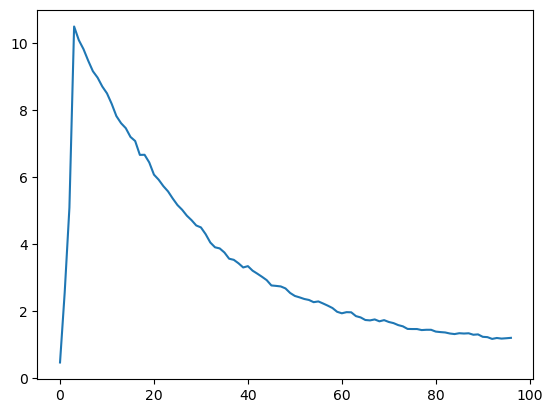

In [20]:
plt.plot(g_train_losses[3:])

Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.19it/s]


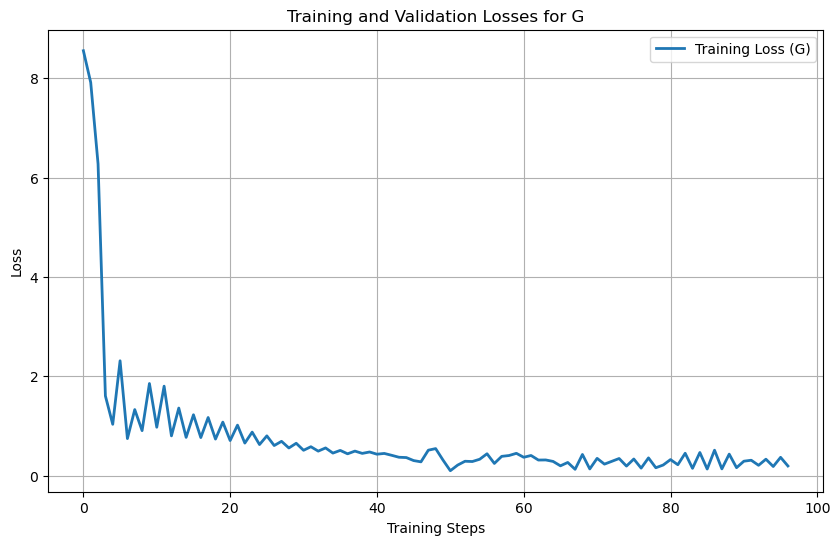

In [23]:
import matplotlib.pyplot as plt

def experiment_and_visualize(dx, dy, r, T, n, lr_phi, lr_g, num_steps):
    # Run the experiment
    params = generate_parameters(dx, dy, r, T)
    params = [n] + list(params)
    data = generate_data(*params)
    g_train_losses, transfer_coeff_before, transfer_coeff_after, _, _, _, _ = experiment(data, dx, dy, r, T, lr_phi, lr_g, num_steps, batch_size, reg_param=reg_param)

    # Plot Training and Validation Losses for G
    plt.figure(figsize=(10, 6))
    plt.plot(g_train_losses[3:], label='Training Loss (G)', linewidth=2)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses for G')
    plt.legend()
    plt.grid()
    plt.show()

    return g_train_losses, transfer_coeff_before, transfer_coeff_after


# Run Experiment and Produce Figures
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

g_train_losses, transfer_coeff_before, transfer_coeff_after = experiment_and_visualize(
    dx, dy, r, T, n, lr_phi, lr_g, num_steps
)


Running trials for reg_param=0...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


Regularizations Mean: 1.028700, Std: 0.010606
Final G Train Loss: 0.4021660387516022
Transfer Coefficient BEFORE: 0.7299695270010443; AFTER: 0.7330140883964861
Avg Train Excess Risks BEFORE: 0.20745328068733215; Avg Train Excess Risk AFTER: 0.18511109054088593
Test Excess Risks BEFORE: 0.2841944396495819; Test Excess Risk AFTER: 0.2525341510772705
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Regularizations Mean: 1.017285, Std: 0.004866
Final G Train Loss: 0.20661813020706177
Transfer Coefficient BEFORE: 0.8311202411720428; AFTER: 0.8276724668715172
Avg Train Excess Risks BEFORE: 0.17367643117904663; Avg Train Excess Risk AFTER: 0.16189056634902954
Test Excess Risks BEFORE: 0.2089666724205017; Test Excess Risk AFTER: 0.19559738039970398
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Regularizations Mean: 1.025380, Std: 0.002407
Final G Train Loss: 0.39284685254096985
Transfer Coefficient BEFORE: 0.768784429948314; AFTER: 0.7715932054091308
Avg Train Excess Risks BEFORE: 0.24084459245204926; Avg Train Excess Risk AFTER: 0.2061285376548767
Test Excess Risks BEFORE: 0.31327974796295166; Test Excess Risk AFTER: 0.26714664697647095
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


Regularizations Mean: 1.020743, Std: 0.008568
Final G Train Loss: 0.2722383141517639
Transfer Coefficient BEFORE: 0.7910138689771952; AFTER: 0.7857498419576564
Avg Train Excess Risks BEFORE: 0.13926798105239868; Avg Train Excess Risk AFTER: 0.13051944971084595
Test Excess Risks BEFORE: 0.17606262862682343; Test Excess Risk AFTER: 0.1661081463098526
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


Regularizations Mean: 1.004495, Std: 0.001922
Final G Train Loss: 0.04986443743109703
Transfer Coefficient BEFORE: 0.8581211573383454; AFTER: 0.861703763646682
Avg Train Excess Risks BEFORE: 0.1498790681362152; Avg Train Excess Risk AFTER: 0.14586909115314484
Test Excess Risks BEFORE: 0.17465956509113312; Test Excess Risk AFTER: 0.16927985846996307
Running trials for reg_param=1...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


Regularizations Mean: 1.012304, Std: 0.002164
Final G Train Loss: 0.08225943893194199
Transfer Coefficient BEFORE: 0.8105300506255263; AFTER: 0.8164354848610461
Avg Train Excess Risks BEFORE: 0.14776918292045593; Avg Train Excess Risk AFTER: 0.14111095666885376
Test Excess Risks BEFORE: 0.1823117882013321; Test Excess Risk AFTER: 0.17283785343170166
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Regularizations Mean: 1.103821, Std: 0.016018
Final G Train Loss: 0.25057458877563477
Transfer Coefficient BEFORE: 0.859531481542254; AFTER: 0.859164703752322
Avg Train Excess Risks BEFORE: 0.31144699454307556; Avg Train Excess Risk AFTER: 0.3107075095176697
Test Excess Risks BEFORE: 0.3623450696468353; Test Excess Risk AFTER: 0.3616390526294708
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Regularizations Mean: 1.117229, Std: 0.014892
Final G Train Loss: 0.46435442566871643
Transfer Coefficient BEFORE: 0.9318424527089394; AFTER: 0.9343546604910241
Avg Train Excess Risks BEFORE: 0.368410587310791; Avg Train Excess Risk AFTER: 0.3679339587688446
Test Excess Risks BEFORE: 0.3953571617603302; Test Excess Risk AFTER: 0.3937840461730957
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Regularizations Mean: 0.850363, Std: 0.000000
Final G Train Loss: 1.1608866453170776
Transfer Coefficient BEFORE: 0.7330987592277496; AFTER: 0.7328110896639166
Avg Train Excess Risks BEFORE: 0.2197619527578354; Avg Train Excess Risk AFTER: 0.21923792362213135
Test Excess Risks BEFORE: 0.2997712790966034; Test Excess Risk AFTER: 0.29917386174201965
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


Regularizations Mean: 0.894276, Std: 0.000000
Final G Train Loss: 0.546794593334198
Transfer Coefficient BEFORE: 0.8728086039106719; AFTER: 0.8728487829609908
Avg Train Excess Risks BEFORE: 0.3994261920452118; Avg Train Excess Risk AFTER: 0.3988623321056366
Test Excess Risks BEFORE: 0.45763319730758667; Test Excess Risk AFTER: 0.4569661319255829
Running trials for reg_param=10...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


Regularizations Mean: 1.023078, Std: 0.004945
Final G Train Loss: 0.22394998371601105
Transfer Coefficient BEFORE: 0.7336339891619651; AFTER: 0.7292086501961308
Avg Train Excess Risks BEFORE: 0.18097351491451263; Avg Train Excess Risk AFTER: 0.1630871295928955
Test Excess Risks BEFORE: 0.24668093025684357; Test Excess Risk AFTER: 0.22364947199821472
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.74it/s]


Regularizations Mean: 0.899934, Std: 0.000000
Final G Train Loss: 1.109885573387146
Transfer Coefficient BEFORE: 0.6784227539681944; AFTER: 0.677603024609028
Avg Train Excess Risks BEFORE: 0.40978309512138367; Avg Train Excess Risk AFTER: 0.4088650941848755
Test Excess Risks BEFORE: 0.6040232181549072; Test Excess Risk AFTER: 0.6033991575241089
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Regularizations Mean: 1.006495, Std: 0.002955
Final G Train Loss: 0.07529191672801971
Transfer Coefficient BEFORE: 0.719459011919197; AFTER: 0.7200548444406696
Avg Train Excess Risks BEFORE: 0.18721064925193787; Avg Train Excess Risk AFTER: 0.16397589445114136
Test Excess Risks BEFORE: 0.2602103054523468; Test Excess Risk AFTER: 0.22772695124149323
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Regularizations Mean: 1.023223, Std: 0.003363
Final G Train Loss: 0.2041211724281311
Transfer Coefficient BEFORE: 0.7667891170577915; AFTER: 0.7709452577657725
Avg Train Excess Risks BEFORE: 0.1570497304201126; Avg Train Excess Risk AFTER: 0.1517283171415329
Test Excess Risks BEFORE: 0.20481476187705994; Test Excess Risk AFTER: 0.19680815935134888
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


Regularizations Mean: 1.007640, Std: 0.006035
Final G Train Loss: 0.19065487384796143
Transfer Coefficient BEFORE: 0.9030882003829226; AFTER: 0.8879931789367219
Avg Train Excess Risks BEFORE: 0.15945802628993988; Avg Train Excess Risk AFTER: 0.14474701881408691
Test Excess Risks BEFORE: 0.17656971514225006; Test Excess Risk AFTER: 0.16300465166568756
Running trials for reg_param=100...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s]


Regularizations Mean: 1.128071, Std: 0.018879
Final G Train Loss: 0.6652470231056213
Transfer Coefficient BEFORE: 0.8910585424573804; AFTER: 0.8915842850676655
Avg Train Excess Risks BEFORE: 0.4095752537250519; Avg Train Excess Risk AFTER: 0.4091058373451233
Test Excess Risks BEFORE: 0.4596502184867859; Test Excess Risk AFTER: 0.4588526785373688
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s]


Regularizations Mean: 0.936042, Std: 0.000000
Final G Train Loss: 0.906777560710907
Transfer Coefficient BEFORE: 0.6274937006999223; AFTER: 0.627083898465499
Avg Train Excess Risks BEFORE: 0.42081406712532043; Avg Train Excess Risk AFTER: 0.4203941822052002
Test Excess Risks BEFORE: 0.6706267595291138; Test Excess Risk AFTER: 0.6703954339027405
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


Regularizations Mean: 1.014738, Std: 0.007308
Final G Train Loss: 0.16636544466018677
Transfer Coefficient BEFORE: 0.8161466232054513; AFTER: 0.8155124552411996
Avg Train Excess Risks BEFORE: 0.26365479826927185; Avg Train Excess Risk AFTER: 0.2631121277809143
Test Excess Risks BEFORE: 0.32304832339286804; Test Excess Risk AFTER: 0.32263410091400146
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


Regularizations Mean: 1.031799, Std: 0.015073
Final G Train Loss: 0.34396684169769287
Transfer Coefficient BEFORE: 0.813827391892343; AFTER: 0.8130766706495567
Avg Train Excess Risks BEFORE: 0.23977960646152496; Avg Train Excess Risk AFTER: 0.2393210232257843
Test Excess Risks BEFORE: 0.2946320176124573; Test Excess Risk AFTER: 0.294340044260025
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.02it/s]


Regularizations Mean: 0.818407, Std: 0.012776
Final G Train Loss: 0.7374635934829712
Transfer Coefficient BEFORE: 0.7543180463538893; AFTER: 0.7544579814070558
Avg Train Excess Risks BEFORE: 0.5233489871025085; Avg Train Excess Risk AFTER: 0.5226581692695618
Test Excess Risks BEFORE: 0.693804144859314; Test Excess Risk AFTER: 0.6927598118782043
Running trials for reg_param=1000...
Trial 1/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


Regularizations Mean: 1.004753, Std: 0.010075
Final G Train Loss: 0.05216541513800621
Transfer Coefficient BEFORE: 0.7080996555692018; AFTER: 0.7080935340644352
Avg Train Excess Risks BEFORE: 0.18521079421043396; Avg Train Excess Risk AFTER: 0.18497668206691742
Test Excess Risks BEFORE: 0.2615603506565094; Test Excess Risk AFTER: 0.2612319886684418
Trial 2/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


Regularizations Mean: 1.013001, Std: 0.005431
Final G Train Loss: 0.4942393898963928
Transfer Coefficient BEFORE: 0.9296379968092443; AFTER: 0.8847219555067548
Avg Train Excess Risks BEFORE: 0.5417852401733398; Avg Train Excess Risk AFTER: 0.44760385155677795
Test Excess Risks BEFORE: 0.5827916264533997; Test Excess Risk AFTER: 0.5059260129928589
Trial 3/5


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


Regularizations Mean: 0.734161, Std: 0.000000
Final G Train Loss: 1.5340325832366943
Transfer Coefficient BEFORE: 0.7720452383970313; AFTER: 0.7717284615069875
Avg Train Excess Risks BEFORE: 0.5122606754302979; Avg Train Excess Risk AFTER: 0.5115166306495667
Test Excess Risks BEFORE: 0.6635112166404724; Test Excess Risk AFTER: 0.6628194451332092
Trial 4/5


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.15it/s]


Regularizations Mean: 1.055377, Std: 0.009918
Final G Train Loss: 0.22768941521644592
Transfer Coefficient BEFORE: 0.8081900059147373; AFTER: 0.7957216153044877
Avg Train Excess Risks BEFORE: 0.5132589340209961; Avg Train Excess Risk AFTER: 0.3948976993560791
Test Excess Risks BEFORE: 0.6350721120834351; Test Excess Risk AFTER: 0.49627619981765747
Trial 5/5


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Regularizations Mean: 0.778658, Std: 0.000000
Final G Train Loss: 1.0001745223999023
Transfer Coefficient BEFORE: 0.884735985051124; AFTER: 0.8863668785158877
Avg Train Excess Risks BEFORE: 0.15707911550998688; Avg Train Excess Risk AFTER: 0.15110112726688385
Test Excess Risks BEFORE: 0.1775434911251068; Test Excess Risk AFTER: 0.17047244310379028


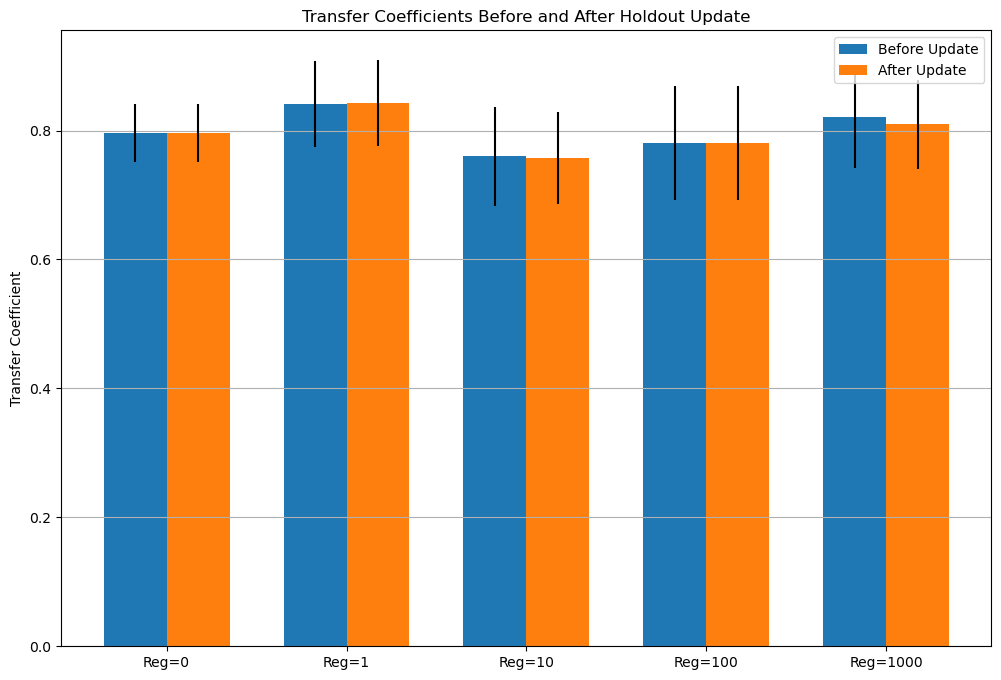

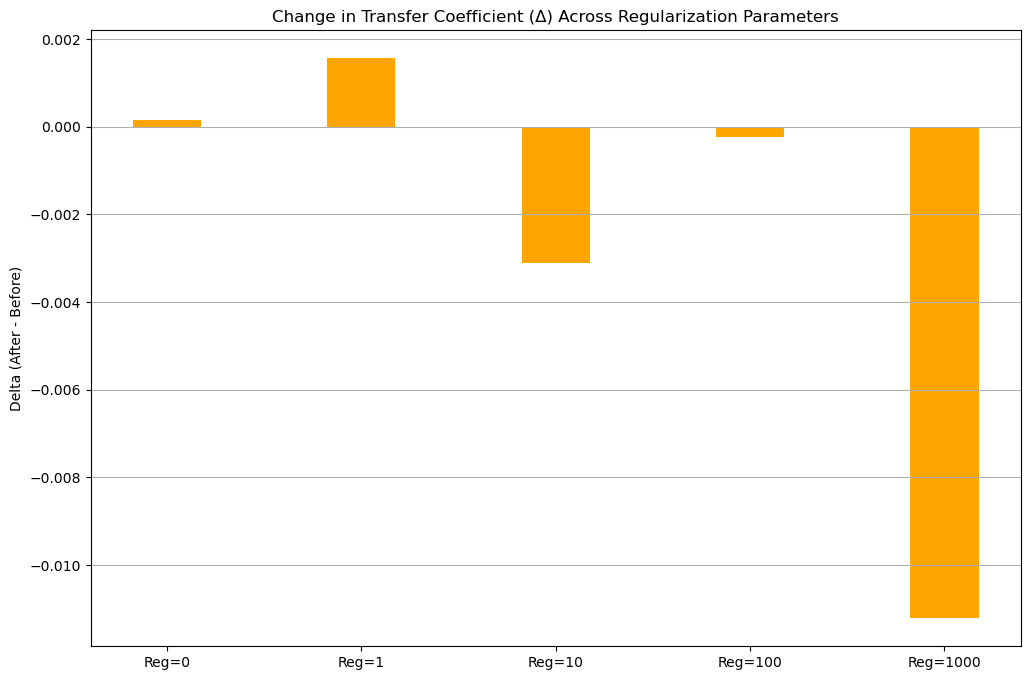

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Run multiple trials for different regularization parameters
def run_trials_and_plot(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=5, reg_params=[0, 1, 10, 100, 1000]):
    trial_results = {reg_param: {"before": [], "after": []} for reg_param in reg_params}

    for reg_param in reg_params:
        print(f"Running trials for reg_param={reg_param}...")
        for trial in range(num_trials):
            print(f"Trial {trial + 1}/{num_trials}")
            _, _, transfer_coeff_before, transfer_coeff_after, _, _, _, _ = experiment(
                dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=32, reg_param=reg_param
            )
            trial_results[reg_param]["before"].append(transfer_coeff_before)
            trial_results[reg_param]["after"].append(transfer_coeff_after)

    # Compute deltas and plot
    reg_param_means = []
    reg_param_stds = []
    deltas = []

    for reg_param in reg_params:
        before_mean = np.mean(trial_results[reg_param]["before"])
        after_mean = np.mean(trial_results[reg_param]["after"])
        delta = after_mean - before_mean
        reg_param_means.append((before_mean, after_mean))
        deltas.append(delta)
        reg_param_stds.append(
            (
                np.std(trial_results[reg_param]["before"]),
                np.std(trial_results[reg_param]["after"]),
            )
        )

    # Bar plot for before and after transfer coefficients
    x = np.arange(len(reg_params))
    bar_width = 0.35
    before_means = [mean[0] for mean in reg_param_means]
    after_means = [mean[1] for mean in reg_param_means]

    plt.figure(figsize=(12, 8))
    plt.bar(x - bar_width / 2, before_means, bar_width, label="Before Update", yerr=[std[0] for std in reg_param_stds])
    plt.bar(x + bar_width / 2, after_means, bar_width, label="After Update", yerr=[std[1] for std in reg_param_stds])
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Transfer Coefficient")
    plt.title("Transfer Coefficients Before and After Holdout Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Plot deltas for each regularization parameter
    plt.figure(figsize=(12, 8))
    plt.bar(x, deltas, color="orange", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Transfer Coefficient (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

# Run the function
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

run_trials_and_plot(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=5, reg_params=[0, 1, 10, 100, 1000])


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.93it/s]


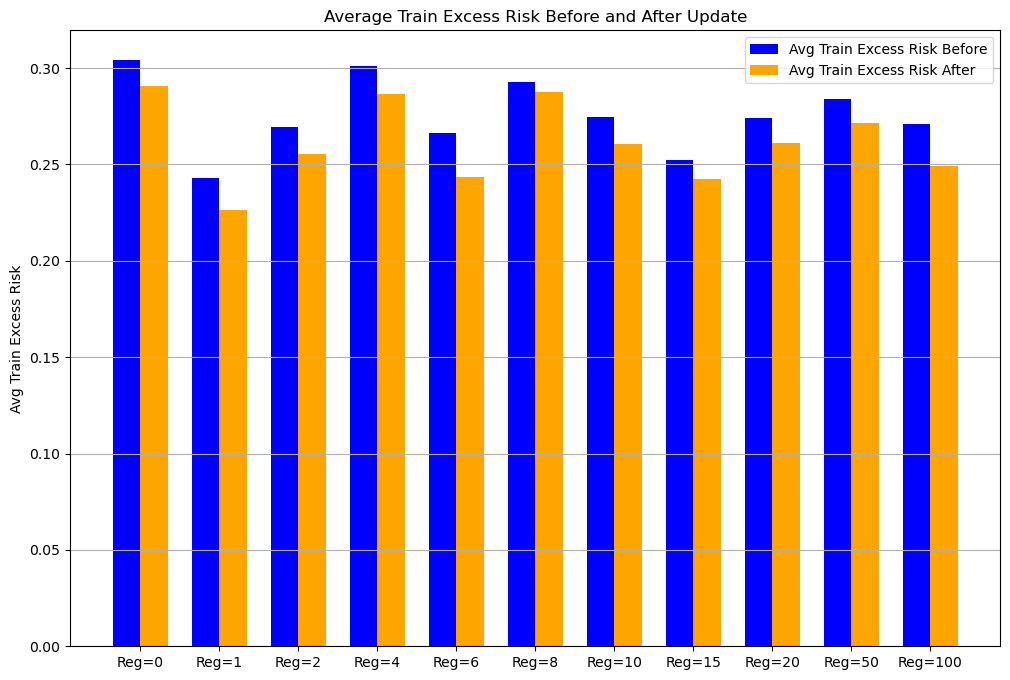

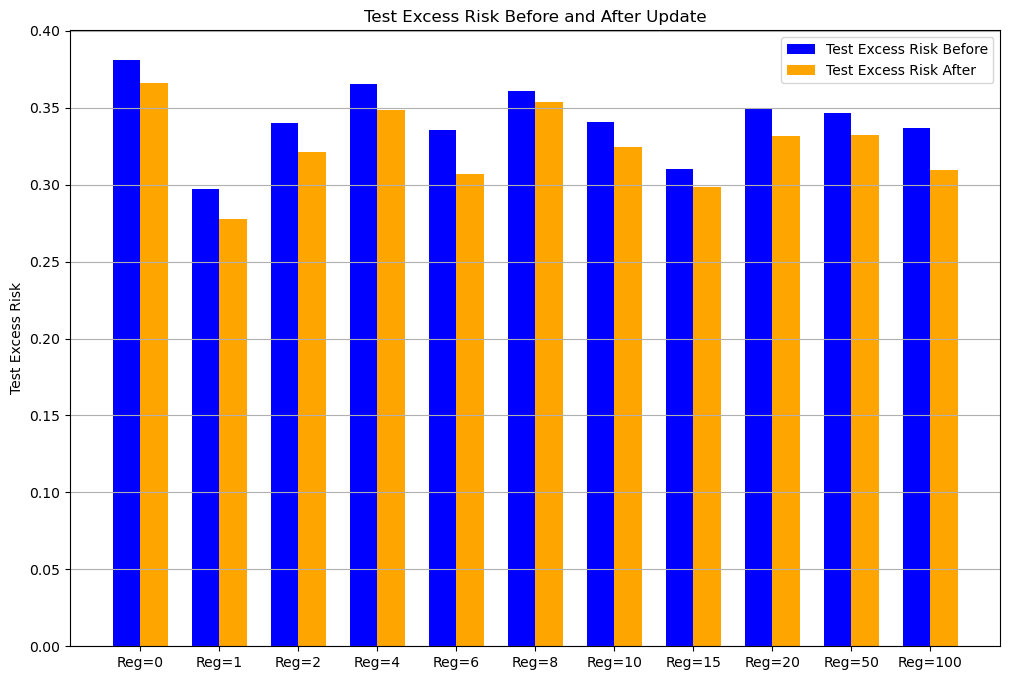

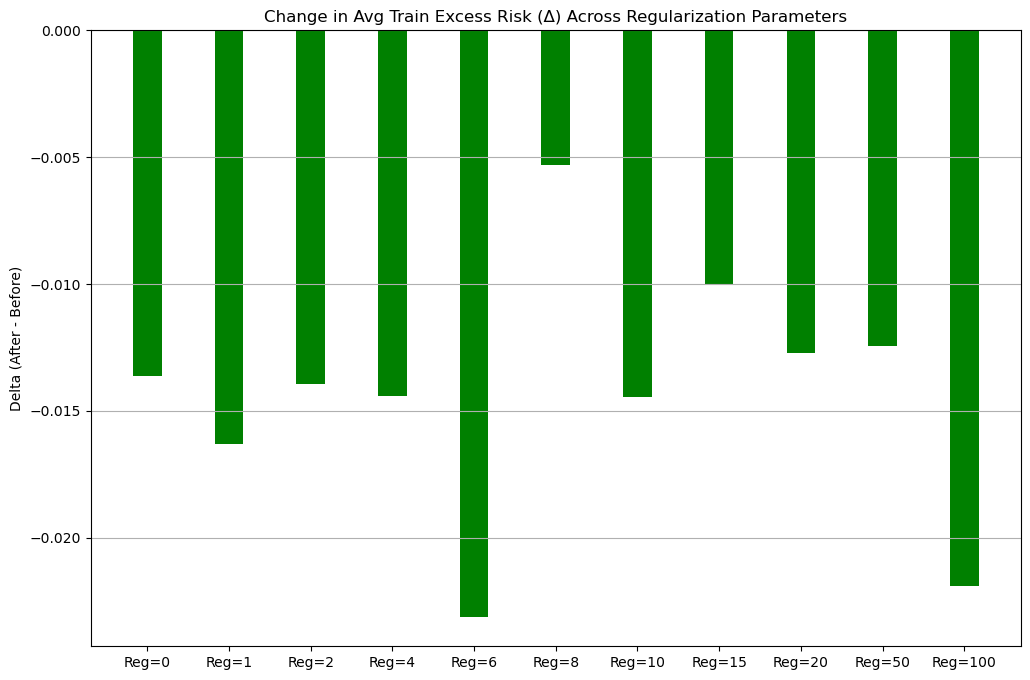

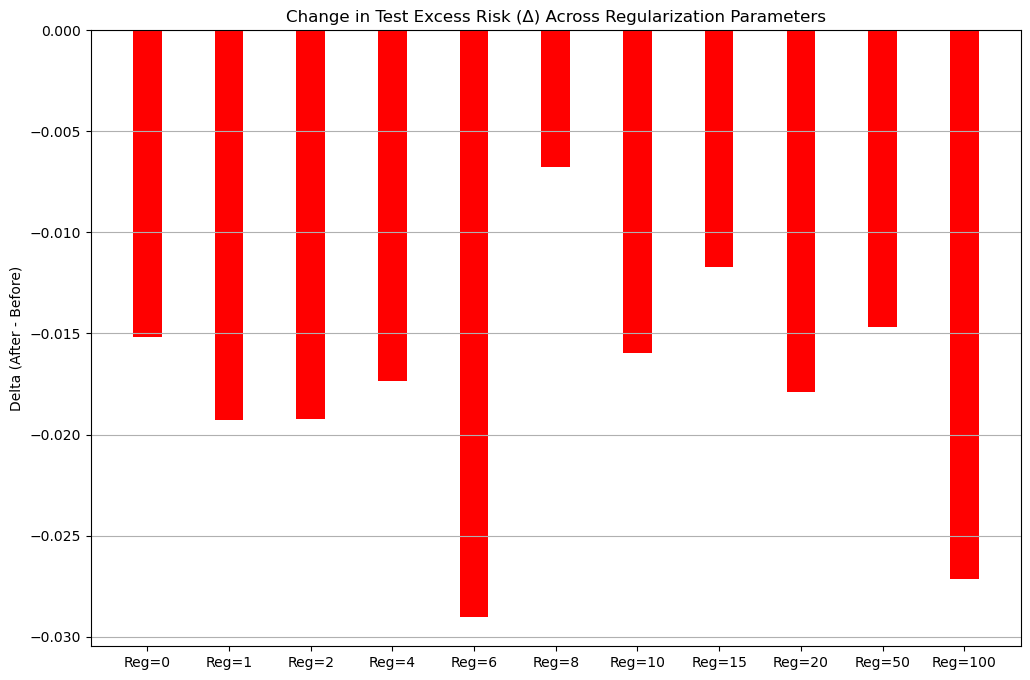

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to run trials and log results to a file
def run_trials_and_plot_risks(
    dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=30, reg_params=[0, 1, 2, 4, 6, 8, 10, 15, 20, 50, 100]
):
    # Prepare log file
    log_file = "experiment_log.txt"
    if os.path.exists(log_file):
        os.remove(log_file)  # Clear existing log file

    with open(log_file, "w") as log:
        # Store results for each regularization parameter
        trial_results = {
            reg_param: {"avg_train_before": [], "avg_train_after": [], "test_before": [], "test_after": []}
            for reg_param in reg_params
        }

        # Run trials for each regularization parameter
        for reg_param in reg_params:
            log.write(f"Running trials for reg_param={reg_param}...\n")
            for trial in range(num_trials):
                log.write(f"  Trial {trial + 1}/{num_trials}\n")
                _, _, _, _, avg_train_before, avg_train_after, test_before, test_after = experiment(
                    dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=32, reg_param=reg_param
                )
                trial_results[reg_param]["avg_train_before"].append(avg_train_before)
                trial_results[reg_param]["avg_train_after"].append(avg_train_after)
                trial_results[reg_param]["test_before"].append(test_before)
                trial_results[reg_param]["test_after"].append(test_after)

        # Compute means and deltas
        avg_train_deltas = []
        test_deltas = []
        for reg_param in reg_params:
            avg_train_before_mean = np.mean(trial_results[reg_param]["avg_train_before"])
            avg_train_after_mean = np.mean(trial_results[reg_param]["avg_train_after"])
            test_before_mean = np.mean(trial_results[reg_param]["test_before"])
            test_after_mean = np.mean(trial_results[reg_param]["test_after"])

            avg_train_deltas.append(avg_train_after_mean - avg_train_before_mean)
            test_deltas.append(test_after_mean - test_before_mean)

            # Log means and deltas
            log.write(
                f"Reg Param {reg_param}: Avg Train Before: {avg_train_before_mean:.6f}, "
                f"Avg Train After: {avg_train_after_mean:.6f}, "
                f"Test Before: {test_before_mean:.6f}, Test After: {test_after_mean:.6f}, "
                f"Delta Train: {avg_train_deltas[-1]:.6f}, Delta Test: {test_deltas[-1]:.6f}\n"
            )

        # Plot avg_train_excess_risk_before and avg_train_excess_risk_after
        plt.figure(figsize=(12, 8))
        x = np.arange(len(reg_params))
        bar_width = 0.35
        avg_train_before_means = [np.mean(trial_results[reg_param]["avg_train_before"]) for reg_param in reg_params]
        avg_train_after_means = [np.mean(trial_results[reg_param]["avg_train_after"]) for reg_param in reg_params]

        plt.bar(
            x - bar_width / 2, avg_train_before_means, bar_width, label="Avg Train Excess Risk Before", color="blue"
        )
        plt.bar(
            x + bar_width / 2, avg_train_after_means, bar_width, label="Avg Train Excess Risk After", color="orange"
        )
        plt.xticks(x, [f"Reg={param}" for param in reg_params])
        plt.ylabel("Avg Train Excess Risk")
        plt.title("Average Train Excess Risk Before and After Update")
        plt.legend()
        plt.grid(axis="y")
        plt.show()

        # Plot test_excess_risk_before and test_excess_risk_after
        plt.figure(figsize=(12, 8))
        test_before_means = [np.mean(trial_results[reg_param]["test_before"]) for reg_param in reg_params]
        test_after_means = [np.mean(trial_results[reg_param]["test_after"]) for reg_param in reg_params]

        plt.bar(
            x - bar_width / 2, test_before_means, bar_width, label="Test Excess Risk Before", color="blue"
        )
        plt.bar(
            x + bar_width / 2, test_after_means, bar_width, label="Test Excess Risk After", color="orange"
        )
        plt.xticks(x, [f"Reg={param}" for param in reg_params])
        plt.ylabel("Test Excess Risk")
        plt.title("Test Excess Risk Before and After Update")
        plt.legend()
        plt.grid(axis="y")
        plt.show()

        # Plot deltas for avg_train_excess_risk
        plt.figure(figsize=(12, 8))
        plt.bar(x, avg_train_deltas, color="green", width=bar_width)
        plt.xticks(x, [f"Reg={param}" for param in reg_params])
        plt.ylabel("Delta (After - Before)")
        plt.title("Change in Avg Train Excess Risk (Δ) Across Regularization Parameters")
        plt.grid(axis="y")
        plt.show()

        # Plot deltas for test_excess_risk
        plt.figure(figsize=(12, 8))
        plt.bar(x, test_deltas, color="red", width=bar_width)
        plt.xticks(x, [f"Reg={param}" for param in reg_params])
        plt.ylabel("Delta (After - Before)")
        plt.title("Change in Test Excess Risk (Δ) Across Regularization Parameters")
        plt.grid(axis="y")
        plt.show()

# Run the function
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100

run_trials_and_plot_risks(dx, dy, r, T, n, lr_phi, lr_g, num_steps)



=== Running Experiments ===

Running Trial 1/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.29it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.98it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.71it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.06it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.23it/s]



Running Trial 2/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.14it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.27it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.95it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.66it/s]



Running Trial 3/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.09it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.14it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]



Running Trial 4/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.47it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.85it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.36it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.20it/s]



Running Trial 5/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 32.14it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.41it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.84it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.55it/s]



Running Trial 6/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.81it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.55it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.00it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.59it/s]



Running Trial 7/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.25it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.02it/s]



Running Trial 8/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.76it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.67it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 34.40it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 33.09it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 31.40it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.73it/s]



Running Trial 9/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 34.83it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 36.86it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 33.40it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 37.14it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 34.34it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 36.32it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 33.05it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]



Running Trial 10/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.55it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 31.31it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 36.27it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.26it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 33.21it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 33.73it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.89it/s]



Running Trial 11/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 33.06it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 33.56it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 36.00it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 32.91it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:10<00:00,  9.82it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]



Running Trial 12/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 35.07it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 36.73it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 31.39it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.57it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 35.55it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 32.66it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 33.75it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:02<00:00, 35.16it/s]



Running Trial 13/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.31it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.66it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.85it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.78it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.83it/s]



Running Trial 14/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.35it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.97it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.48it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 33.03it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.61it/s]



Running Trial 15/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.79it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.61it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.55it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.83it/s]



Running Trial 16/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.29it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.69it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.26it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.36it/s]



Running Trial 17/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.77it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.87it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.62it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]



Running Trial 18/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]



Running Trial 19/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.37it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.37it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.76it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]



Running Trial 20/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.60it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.91it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.85it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.05it/s]



Running Trial 21/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.65it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.39it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.28it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.35it/s]



Running Trial 22/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.74it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.52it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]



Running Trial 23/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]



Running Trial 24/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]



Running Trial 25/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.06it/s]



Running Trial 26/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.10it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.40it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.87it/s]



Running Trial 27/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.19it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 30.52it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.89it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.45it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]



Running Trial 28/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.38it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.03it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.14it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]



Running Trial 29/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.00it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.02it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.31it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 16.80it/s]



Running Trial 30/30...
  Running experiment with reg_param=0...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.95it/s]


  Running experiment with reg_param=1...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.99it/s]


  Running experiment with reg_param=2...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.50it/s]


  Running experiment with reg_param=4...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.85it/s]


  Running experiment with reg_param=6...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


  Running experiment with reg_param=8...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.45it/s]


  Running experiment with reg_param=10...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.49it/s]


  Running experiment with reg_param=100...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.12it/s]


  Running experiment with reg_param=1000...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]



=== Experiments Completed ===


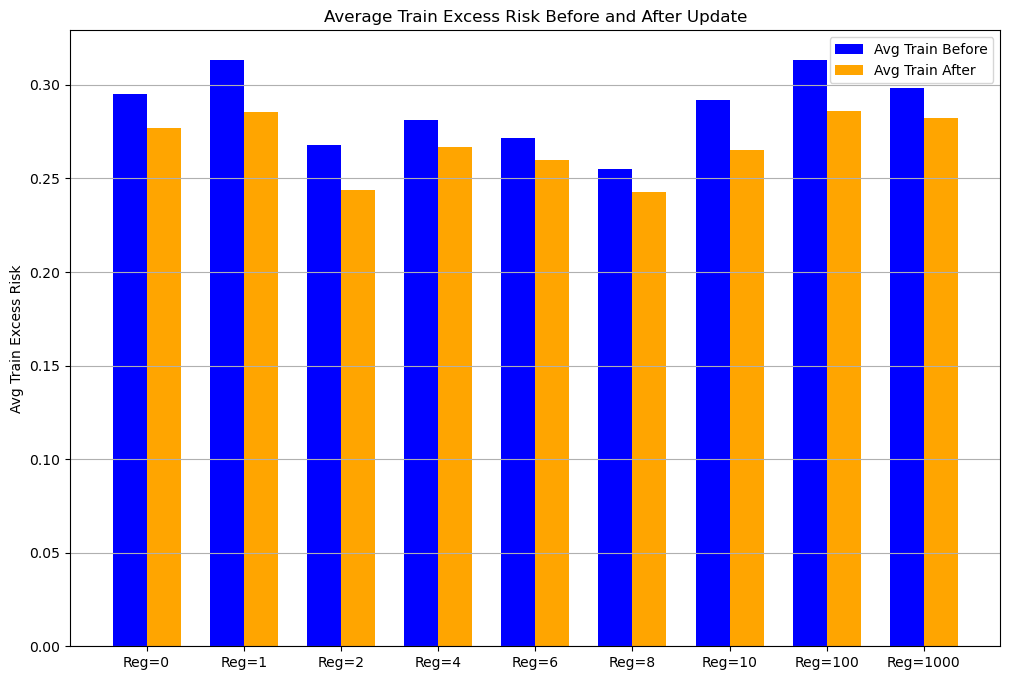

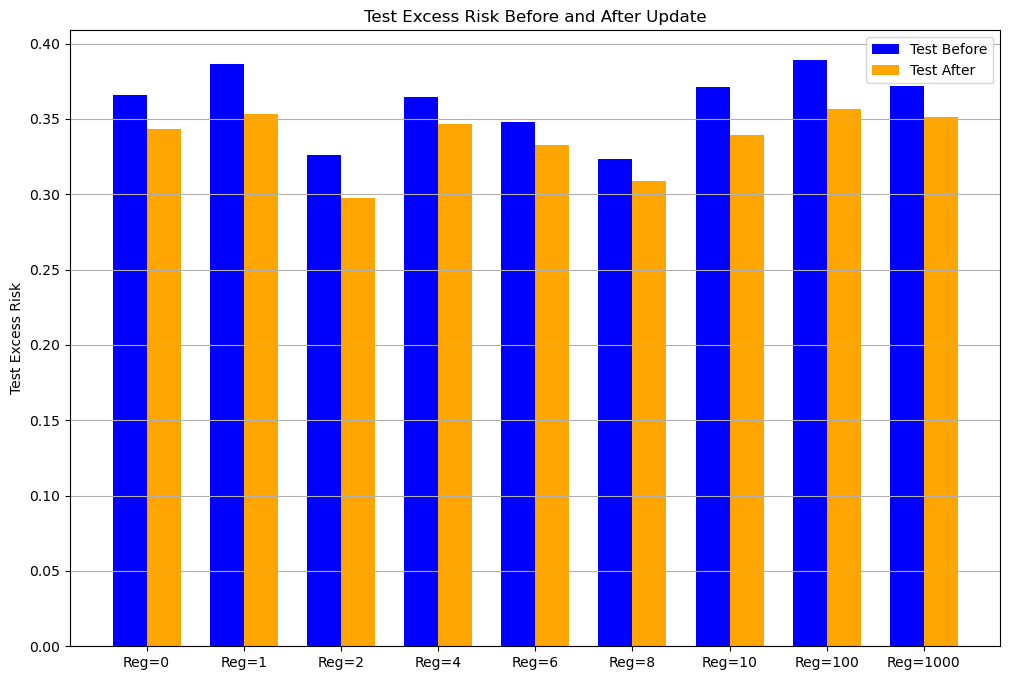

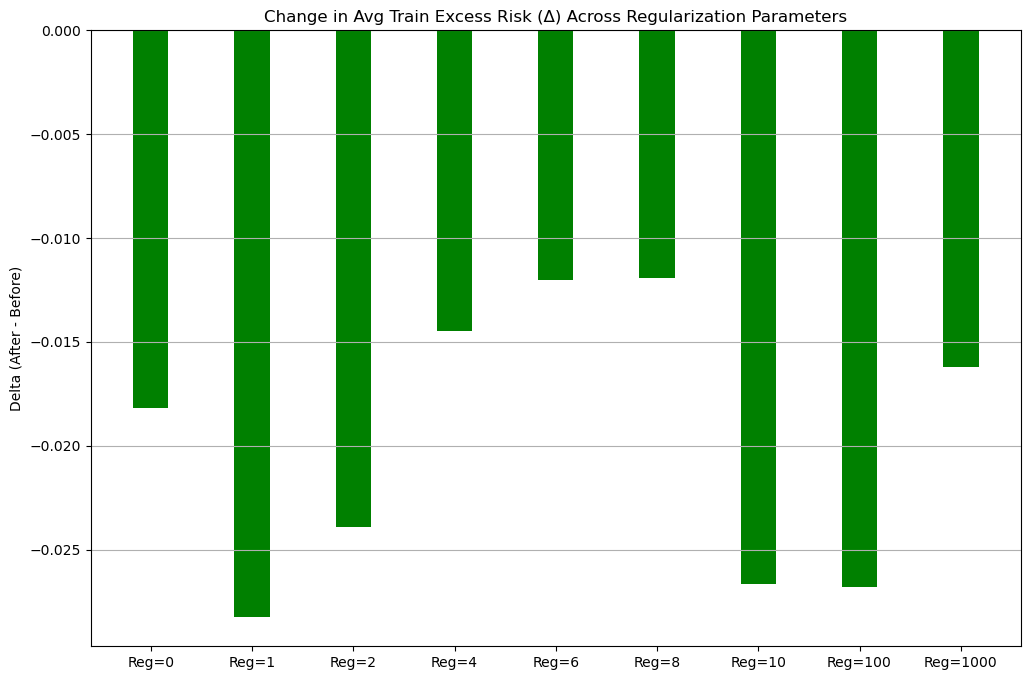

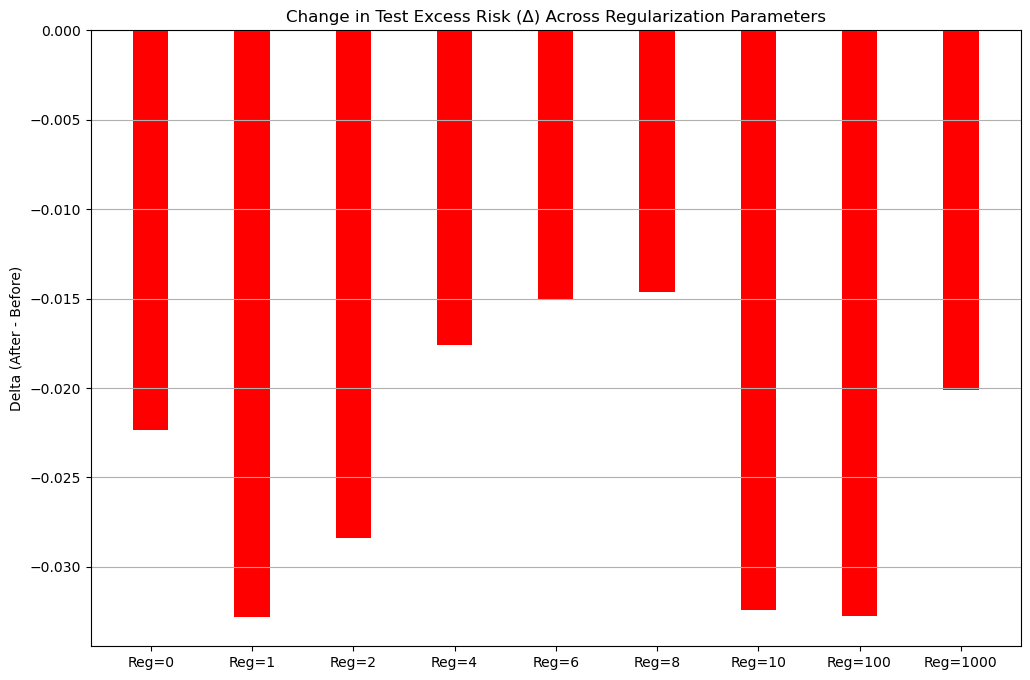

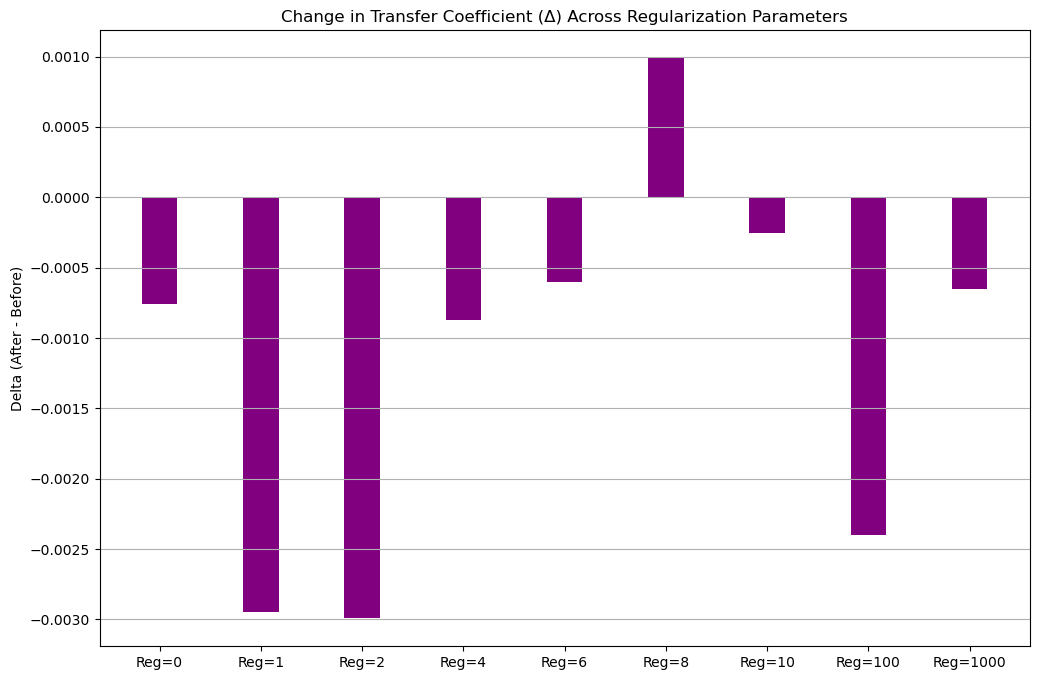

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

def run_trials_with_constant_dataset(
    dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials=10, reg_params=[0, 1, 2, 4, 6, 8, 10, 100, 1000], log_file="experiment_log.txt"
):
    """
    Run trials for multiple regularization parameters while holding the dataset constant.

    Args:
        dx, dy, r, T: Dimensions and task count.
        n: Number of samples per task.
        lr_phi, lr_g: Learning rates for Φ and G.
        num_steps: Number of training steps.
        num_trials: Number of trials.
        reg_params: List of regularization parameters.
        log_file: Name of the log file to store results.

    Returns:
        trial_results: Dictionary containing results for all trials and regularization parameters.
    """
    # Prepare log file
    if os.path.exists(log_file):
        os.remove(log_file)

    with open(log_file, "w") as log:
        # Store results for each regularization parameter
        trial_results = {
            reg_param: {
                "avg_train_before": [],
                "avg_train_after": [],
                "test_before": [],
                "test_after": [],
                "transfer_coeff_before": [],
                "transfer_coeff_after": [],
            }
            for reg_param in reg_params
        }

        # Run trials
        print("\n=== Running Experiments ===")
        for trial in range(num_trials):
            print(f"\nRunning Trial {trial + 1}/{num_trials}...")
            log.write(f"Trial {trial + 1}/{num_trials}\n")

            # Generate a single dataset for this trial
            params = generate_parameters(dx, dy, r, T)
            params = [n] + list(params)
            data = generate_data(*params)

            for reg_param in reg_params:
                print(f"  Running experiment with reg_param={reg_param}...")
                log.write(f"  Reg Param {reg_param}\n")

                # Run experiment with the same dataset but different regularization
                _, transfer_coeff_before, transfer_coeff_after, avg_train_before, avg_train_after, test_before, test_after = experiment(
                    data, dx, dy, r, T, lr_phi, lr_g, num_steps, batch_size=32, reg_param=reg_param
                )

                # Store results
                trial_results[reg_param]["avg_train_before"].append(avg_train_before)
                trial_results[reg_param]["avg_train_after"].append(avg_train_after)
                trial_results[reg_param]["test_before"].append(test_before)
                trial_results[reg_param]["test_after"].append(test_after)
                trial_results[reg_param]["transfer_coeff_before"].append(transfer_coeff_before)
                trial_results[reg_param]["transfer_coeff_after"].append(transfer_coeff_after)

                # Log results
                log.write(
                    f"    Avg Train Before: {avg_train_before:.6f}, Avg Train After: {avg_train_after:.6f}, "
                    f"Test Before: {test_before:.6f}, Test After: {test_after:.6f}, "
                    f"Transfer Coeff Before: {transfer_coeff_before:.6f}, Transfer Coeff After: {transfer_coeff_after:.6f}\n"
                )

        print("\n=== Experiments Completed ===")

    # Visualize results
    visualize_results(trial_results, reg_params)
    return trial_results


def visualize_results(trial_results, reg_params):
    """
    Visualize the results of the experiments.

    Args:
        trial_results: Dictionary containing results from the trials.
        reg_params: List of regularization parameters.
    """
    avg_train_deltas = []
    test_deltas = []
    transfer_coeff_deltas = []

    for reg_param in reg_params:
        avg_train_before_mean = np.mean(trial_results[reg_param]["avg_train_before"])
        avg_train_after_mean = np.mean(trial_results[reg_param]["avg_train_after"])
        test_before_mean = np.mean(trial_results[reg_param]["test_before"])
        test_after_mean = np.mean(trial_results[reg_param]["test_after"])
        transfer_coeff_before_mean = np.mean(trial_results[reg_param]["transfer_coeff_before"])
        transfer_coeff_after_mean = np.mean(trial_results[reg_param]["transfer_coeff_after"])

        avg_train_deltas.append(avg_train_after_mean - avg_train_before_mean)
        test_deltas.append(test_after_mean - test_before_mean)
        transfer_coeff_deltas.append(transfer_coeff_after_mean - transfer_coeff_before_mean)

    x = np.arange(len(reg_params))
    bar_width = 0.35

    # Avg Train Excess Risk Before and After
    avg_train_before_means = [np.mean(trial_results[reg_param]["avg_train_before"]) for reg_param in reg_params]
    avg_train_after_means = [np.mean(trial_results[reg_param]["avg_train_after"]) for reg_param in reg_params]

    plt.figure(figsize=(12, 8))
    plt.bar(
        x - bar_width / 2, avg_train_before_means, bar_width, label="Avg Train Before", color="blue"
    )
    plt.bar(
        x + bar_width / 2, avg_train_after_means, bar_width, label="Avg Train After", color="orange"
    )
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Avg Train Excess Risk")
    plt.title("Average Train Excess Risk Before and After Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Test Excess Risk Before and After
    test_before_means = [np.mean(trial_results[reg_param]["test_before"]) for reg_param in reg_params]
    test_after_means = [np.mean(trial_results[reg_param]["test_after"]) for reg_param in reg_params]

    plt.figure(figsize=(12, 8))
    plt.bar(
        x - bar_width / 2, test_before_means, bar_width, label="Test Before", color="blue"
    )
    plt.bar(
        x + bar_width / 2, test_after_means, bar_width, label="Test After", color="orange"
    )
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Test Excess Risk")
    plt.title("Test Excess Risk Before and After Update")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    # Delta for Avg Train Excess Risk
    plt.figure(figsize=(12, 8))
    plt.bar(x, avg_train_deltas, color="green", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Avg Train Excess Risk (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

    # Delta for Test Excess Risk
    plt.figure(figsize=(12, 8))
    plt.bar(x, test_deltas, color="red", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Test Excess Risk (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()

    # Delta for Transfer Coefficient
    plt.figure(figsize=(12, 8))
    plt.bar(x, transfer_coeff_deltas, color="purple", width=bar_width)
    plt.xticks(x, [f"Reg={param}" for param in reg_params])
    plt.ylabel("Delta (After - Before)")
    plt.title("Change in Transfer Coefficient (Δ) Across Regularization Parameters")
    plt.grid(axis="y")
    plt.show()


# ==== Main Script ====

# Experiment parameters
dx, dy, r, T = 50, 15, 5, 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100
num_trials = 30
reg_params = [0, 1, 10, 100, 1000]

# Run the experiment
trial_results = run_trials_with_constant_dataset(dx, dy, r, T, n, lr_phi, lr_g, num_steps, num_trials)


## Updating the representation with regularized steps according to G once loss is sufficiently low

In [57]:
def experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=64, split_ratio=0.8, reg_param=1, g_loss_threshold=0.01):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Partition data for training, risk computation, and validation
    X_phi_train, Y_phi_train, X_risk, Y_risk = [], [], [], []
    for t in range(T):
        split_idx = int(split_ratio * X_train[t].shape[1])
        X_phi_train.append(X_train[t][:, :split_idx].to(device))  # Training subset
        Y_phi_train.append(Y_train[t][:, :split_idx].to(device))
        X_risk.append(X_train[t][:, split_idx:].to(device))       # Excess risk subset
        Y_risk.append(Y_train[t][:, split_idx:].to(device))

    # Separate holdout task
    X_holdout_train, Y_holdout_train = X_train[-1][:, :split_idx].to(device), Y_train[-1][:, :split_idx].to(device)
    X_holdout_test, Y_holdout_test = X_test[-1].to(device), Y_test[-1].to(device)
    Ws = [w.to(device) for w in Ws]

    # Initialize models and optimizers
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    G_model = GNet(4339, 1).to(device)  # Adjust input size for flattened embeddings
    optimizer_phi = optim.SGD(Phi.parameters(), lr=lr_phi)
    optimizer_g = optim.SGD(G_model.parameters(), lr=lr_g)
    criterion = nn.MSELoss()
    g_criterion = nn.MSELoss()
    g_train_losses = []

    # Helper: Sample a random batch
    def get_batch(X, Y, batch_size):
        indices = torch.randperm(X.shape[1])[:batch_size]
        return X[:, indices], Y[:, indices]

    # Training loop
    for step in tqdm(range(num_steps), desc="Training Steps", leave=True):
        # Step 1: Train \( G \) with batch sampling
        optimizer_g.zero_grad()
        embeddings = []
        total_loss = 0.0

        # Compute excess risks and heads for \( G \)
        heads = [least_squares_head(X_risk[t].T, Y_risk[t].T, Phi) for t in range(T)]
        flattened_heads = [h.flatten() for h in heads]
        flattened_Phi = torch.cat([p.flatten() for p in Phi.parameters()], dim=0)
        excess_risks = torch.tensor(
            [excess_risk(X_risk[t].T, Y_risk[t].T, heads[t], Phi, Ws[t])
             for t in range(T)], device=device)

        masks = ~torch.eye(T, dtype=torch.bool, device=device)  # Exclude each task one at a time
        remaining_excess_risks = torch.sum(excess_risks.unsqueeze(0) * masks, dim=1)
        avg_remaining_excess_risks = remaining_excess_risks / masks.sum(dim=1)
        transfer_coeffs = avg_remaining_excess_risks / excess_risks  # Compute transfer coefficients

        g_train_loss = 0.0
        for t in range(T):
            flattened_input = torch.cat(
                [flattened_Phi, torch.cat(flattened_heads[:t] + flattened_heads[t + 1:], dim=0), flattened_heads[t]],
                dim=0
            )
            g_preds = G_model(flattened_input.unsqueeze(0))
            g_train_loss += g_criterion(g_preds.squeeze(), transfer_coeffs[t].detach())
        g_train_loss.backward()
        optimizer_g.step()
        g_train_losses.append(g_train_loss.item())

        # Step 2: Train \( \Phi \) only if \( G \)'s loss is sufficiently low
        
        optimizer_phi.zero_grad()
        total_phi_loss = 0.0
        for t in range(T):
            x_batch, y_batch = get_batch(X_phi_train[t], Y_phi_train[t], batch_size)
            embeddings = Phi(x_batch.T)  # Shape: (batch_size, r)
            F_t = least_squares_head(x_batch.T, y_batch.T, Phi)
            preds = F_t @ embeddings.T
            loss = criterion(preds.T, y_batch.T)
            total_phi_loss += loss

        # Regularization by \( G \)
        avg_regularization = 0.0
        if g_train_loss.item() < g_loss_threshold:
            regularizations = []
            for leave_out_t in range(T):
                flattened_input = torch.cat(
                    [
                        flattened_Phi,
                        torch.cat(flattened_heads[:leave_out_t] + flattened_heads[leave_out_t + 1:], dim=0),
                        flattened_heads[leave_out_t]
                    ],
                    dim=0
                )
                regularization = G_model(flattened_input.unsqueeze(0)).item()
                regularizations.append(regularization)
            avg_regularization = sum(regularizations) / T
        
        total_phi_loss += reg_param * avg_regularization
        total_phi_loss.backward()
        optimizer_phi.step()

    # Evaluate Transfer Coefficients BEFORE and AFTER Holdout Update
    F_holdout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_before = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout, Phi, Ws[-1])
    avg_train_excess_risk_before = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_before = avg_train_excess_risk_before / test_excess_risk_before.item()

    F_holdout_updated = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk_after = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_holdout_updated, Phi, Ws[-1])
    avg_train_excess_risk_after = torch.mean(
        torch.tensor([excess_risk(X_risk[t].T, Y_risk[t].T,
                                  least_squares_head(X_risk[t].T, Y_risk[t].T, Phi),
                                  Phi, Ws[t])
                      for t in range(T - 1)], device=device)).item()
    transfer_coeff_after = avg_train_excess_risk_after / test_excess_risk_after.item()

    return g_train_losses, [], transfer_coeff_before, transfer_coeff_after, avg_train_excess_risk_before, avg_train_excess_risk_after, test_excess_risk_before.item(), test_excess_risk_after.item()


# Experiment parameters
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100
batch_size = 32
g_loss_threshold = 0.5

outputs1 = experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=batch_size, reg_param=0, g_loss_threshold=g_loss_threshold)
outputs2 = experiment(dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=batch_size, reg_param=10, g_loss_threshold=g_loss_threshold)



Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


In [54]:
print(outputs1)
print(outputs2)

([12.599359512329102, 102.73674774169922, 12.039599418640137, 11.450074195861816, 11.000468254089355, 10.571474075317383, 10.159967422485352, 9.765229225158691, 9.386699676513672, 9.02367877960205, 8.674958229064941, 8.339946746826172, 8.018020629882812, 7.708559513092041, 7.410958290100098, 7.12437105178833, 6.842650890350342, 6.56334114074707, 6.241676330566406, 5.742060661315918, 4.705869674682617, 2.5234174728393555, 0.326198011636734, 0.19565269351005554, 0.3560360372066498, 0.2969838082790375, 0.3199118673801422, 0.28558194637298584, 0.39504700899124146, 0.6330724358558655, 0.6207086443901062, 0.9214972257614136, 0.5658905506134033, 0.7337160706520081, 0.47862011194229126, 0.5905600786209106, 0.41668152809143066, 0.5120508074760437, 0.39223194122314453, 0.4206201434135437, 0.37158748507499695, 0.399694561958313, 0.36168867349624634, 0.3984033465385437, 0.3507256507873535, 0.3553047776222229, 0.3314876854419708, 0.3634370267391205, 0.32505542039871216, 0.3542783260345459, 0.356974

Running experiments with reg_param=0...
  Trial 1/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


  Trial 1/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


  Trial 2/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.03it/s]


  Trial 2/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


  Trial 3/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.76it/s]


  Trial 3/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.66it/s]


  Trial 4/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.68it/s]


  Trial 4/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


  Trial 5/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


  Trial 5/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.38it/s]


Running experiments with reg_param=1...
  Trial 1/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


  Trial 1/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


  Trial 2/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


  Trial 2/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.05it/s]


  Trial 3/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


  Trial 3/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.28it/s]


  Trial 4/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


  Trial 4/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.48it/s]


  Trial 5/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


  Trial 5/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Running experiments with reg_param=5...
  Trial 1/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


  Trial 1/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


  Trial 2/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


  Trial 2/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.39it/s]


  Trial 3/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 21.44it/s]


  Trial 3/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.14it/s]


  Trial 4/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


  Trial 4/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


  Trial 5/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


  Trial 5/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.97it/s]


Running experiments with reg_param=10...
  Trial 1/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.07it/s]


  Trial 1/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.58it/s]


  Trial 2/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


  Trial 2/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.59it/s]


  Trial 3/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


  Trial 3/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


  Trial 4/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.43it/s]


  Trial 4/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


  Trial 5/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


  Trial 5/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 23.58it/s]


Running experiments with reg_param=20...
  Trial 1/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.73it/s]


  Trial 1/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


  Trial 2/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


  Trial 2/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


  Trial 3/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


  Trial 3/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


  Trial 4/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


  Trial 4/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:04<00:00, 22.36it/s]


  Trial 5/5 (Regularized)...


Training Steps: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


  Trial 5/5 (Unregularized)...


Training Steps: 100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


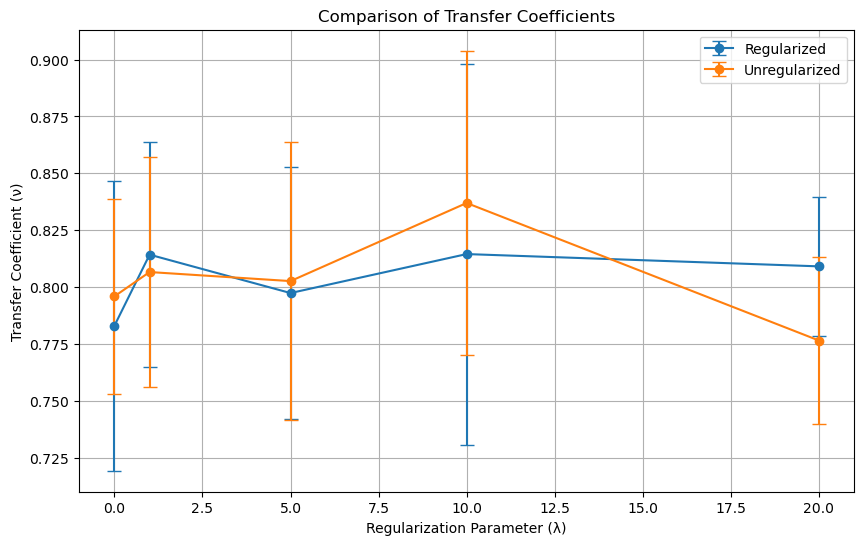

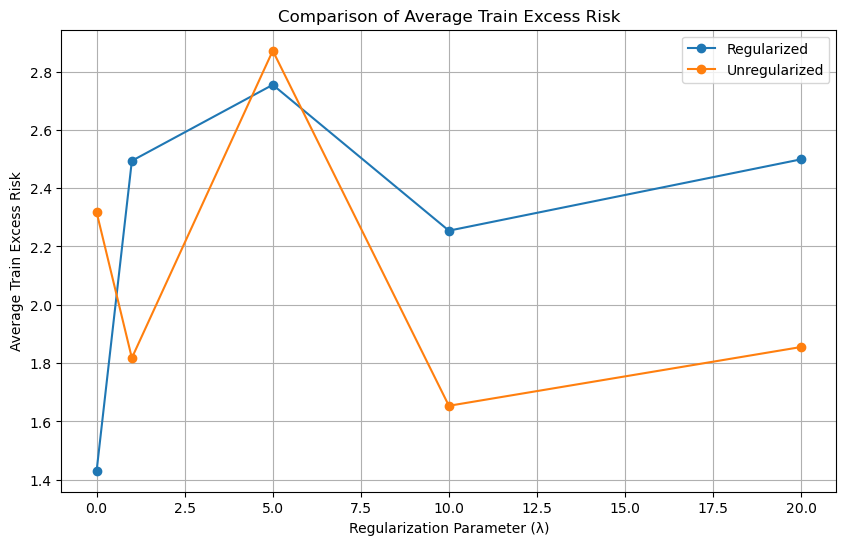

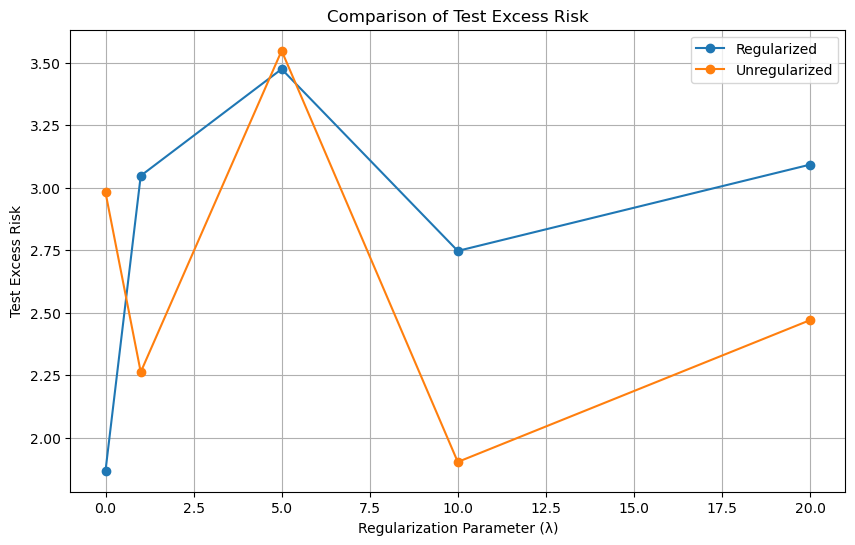

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def run_and_compare_regularized_training(dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size, g_loss_threshold, reg_param_values, num_trials=5):
    """
    Run experiments with and without \( G \)-based regularization and compare results.

    Args:
        dx, dy, r, T, n, lr_phi, lr_g: Experiment parameters.
        num_steps: Number of training steps.
        batch_size: Batch size for training.
        g_loss_threshold: Threshold for \( G \)'s loss to trigger \( \Phi \) updates.
        reg_param_values: List of regularization parameters to test.
        num_trials: Number of trials per configuration.

    Returns:
        Results dictionary with metrics for visualization.
    """
    results = {
        "regularized": {"transfer_coeffs": [], "avg_train_excess_risks": [], "test_excess_risks": []},
        "unregularized": {"transfer_coeffs": [], "avg_train_excess_risks": [], "test_excess_risks": []}
    }

    for reg_param in reg_param_values:
        print(f"Running experiments with reg_param={reg_param}...")

        reg_transfer_coeffs = []
        unreg_transfer_coeffs = []

        reg_train_excess_risks = []
        unreg_train_excess_risks = []

        reg_test_excess_risks = []
        unreg_test_excess_risks = []

        for trial in range(num_trials):
            print(f"  Trial {trial + 1}/{num_trials} (Regularized)...")
            _, _, tc_before_reg, tc_after_reg, train_ex_before_reg, train_ex_after_reg, test_ex_before_reg, test_ex_after_reg = experiment(
                dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=batch_size, reg_param=reg_param, g_loss_threshold=g_loss_threshold
            )
            reg_transfer_coeffs.append(tc_after_reg)
            reg_train_excess_risks.append(train_ex_after_reg)
            reg_test_excess_risks.append(test_ex_after_reg)

            print(f"  Trial {trial + 1}/{num_trials} (Unregularized)...")
            _, _, tc_before_unreg, tc_after_unreg, train_ex_before_unreg, train_ex_after_unreg, test_ex_before_unreg, test_ex_after_unreg = experiment(
                dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size=batch_size, reg_param=0, g_loss_threshold=g_loss_threshold
            )
            unreg_transfer_coeffs.append(tc_after_unreg)
            unreg_train_excess_risks.append(train_ex_after_unreg)
            unreg_test_excess_risks.append(test_ex_after_unreg)

        results["regularized"]["transfer_coeffs"].append(reg_transfer_coeffs)
        results["unregularized"]["transfer_coeffs"].append(unreg_transfer_coeffs)

        results["regularized"]["avg_train_excess_risks"].append(reg_train_excess_risks)
        results["unregularized"]["avg_train_excess_risks"].append(unreg_train_excess_risks)

        results["regularized"]["test_excess_risks"].append(reg_test_excess_risks)
        results["unregularized"]["test_excess_risks"].append(unreg_test_excess_risks)

    return results


def plot_comparisons(results, reg_param_values):
    """
    Plot comparisons between regularized and unregularized experiments.

    Args:
        results: Results dictionary from `run_and_compare_regularized_training`.
        reg_param_values: List of regularization parameters tested.
    """
    # Prepare data
    reg_transfer_means = [np.mean(results["regularized"]["transfer_coeffs"][i]) for i in range(len(reg_param_values))]
    unreg_transfer_means = [np.mean(results["unregularized"]["transfer_coeffs"][i]) for i in range(len(reg_param_values))]
    
    reg_transfer_stds = [np.std(results["regularized"]["transfer_coeffs"][i]) for i in range(len(reg_param_values))]
    unreg_transfer_stds = [np.std(results["unregularized"]["transfer_coeffs"][i]) for i in range(len(reg_param_values))]

    reg_train_means = [np.mean(results["regularized"]["avg_train_excess_risks"][i]) for i in range(len(reg_param_values))]
    unreg_train_means = [np.mean(results["unregularized"]["avg_train_excess_risks"][i]) for i in range(len(reg_param_values))]
    
    reg_test_means = [np.mean(results["regularized"]["test_excess_risks"][i]) for i in range(len(reg_param_values))]
    unreg_test_means = [np.mean(results["unregularized"]["test_excess_risks"][i]) for i in range(len(reg_param_values))]

    # Transfer Coefficients
    plt.figure(figsize=(10, 6))
    plt.errorbar(reg_param_values, reg_transfer_means, yerr=reg_transfer_stds, fmt="-o", capsize=5, label="Regularized")
    plt.errorbar(reg_param_values, unreg_transfer_means, yerr=unreg_transfer_stds, fmt="-o", capsize=5, label="Unregularized")
    plt.xlabel("Regularization Parameter (λ)")
    plt.ylabel("Transfer Coefficient (ν)")
    plt.title("Comparison of Transfer Coefficients")
    plt.legend()
    plt.grid()
    plt.show()

    # Average Train Excess Risks
    plt.figure(figsize=(10, 6))
    plt.plot(reg_param_values, reg_train_means, "-o", label="Regularized")
    plt.plot(reg_param_values, unreg_train_means, "-o", label="Unregularized")
    plt.xlabel("Regularization Parameter (λ)")
    plt.ylabel("Average Train Excess Risk")
    plt.title("Comparison of Average Train Excess Risk")
    plt.legend()
    plt.grid()
    plt.show()

    # Test Excess Risks
    plt.figure(figsize=(10, 6))
    plt.plot(reg_param_values, reg_test_means, "-o", label="Regularized")
    plt.plot(reg_param_values, unreg_test_means, "-o", label="Unregularized")
    plt.xlabel("Regularization Parameter (λ)")
    plt.ylabel("Test Excess Risk")
    plt.title("Comparison of Test Excess Risk")
    plt.legend()
    plt.grid()
    plt.show()


# Experiment parameters
dx, dy, r = 50, 15, 5
T = 10
n = 320
lr_phi = 0.01
lr_g = 0.001
num_steps = 100
batch_size = 32
g_loss_threshold = 0.5
reg_param_values = [0, 1, 5, 10, 20]  # Regularization parameter values

# Run experiments
results = run_and_compare_regularized_training(
    dx, dy, r, T, n, lr_phi, lr_g, num_steps, batch_size, g_loss_threshold, reg_param_values
)

# Plot comparisons
plot_comparisons(results, reg_param_values)
